In [1]:
# Upload the local data file to colab
from google.colab import files
uploaded = files.upload()

Saving pathways.csv to pathways.csv
Saving data_mutations_short.csv to data_mutations_short.csv
Saving Mutated_Genes.csv to Mutated_Genes.csv
Saving glioma_mskcc_2019_clinical_data_simpler.csv to glioma_mskcc_2019_clinical_data_simpler.csv


In [2]:
# Installation of necessary libraries
!pip install bravado
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install geneview
!pip install gprofiler-official
!pip install statsmodels
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.7 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67675 sha256=3cf2bc8d56c423e9cfdcb0a1e5d379ea20877aa03d6c514c81629b40b3e479cb
  Stored in directory: /root/.cache/pip/wheels/42/35/4a/44ec4c358db21a5d63ed4e40f0f0012a438106f220bce4ccba
Successfully built bravado-core
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for geneview: filename=geneview-0.2.1-py3-none-any.whl size=54473 sha256=826411951e62400a44241c9d4d5e8ef2215b88ef11fe718e1ad907332bc49f39
  Stored in directory: /root/.cache/pip/wheels/91/cb/65/81dafd0254adb97b0938e9c3da9c2c74a8e6169e4595437ca7
Successfully built geneview


In [3]:
# import libraries to use
import bravado
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geneview
from gprofiler import GProfiler
import statsmodels.api as sm
from sklearn import datasets, model_selection, metrics
import math


In [4]:
# Read the data in the glioma_mskcc_2019_clinical_data_simpler.csv file into a dataframe
clinical = pd.read_csv('glioma_mskcc_2019_clinical_data_simpler.csv', sep=",")
# Read the data in the data_mutations_short.csv file into a dataframe
mutations = pd.read_csv('data_mutations_short.csv', sep=",")
# Read the data in the Mutated_Genes.csv file into a dataframe
genes = pd.read_csv('Mutated_Genes.csv', sep=",")

In [5]:
# Parsing pathways csv
# Load the CSV file with default separator
pathways = pd.read_csv('pathways.csv')

# Step 1: Split the 'Pathway,Genes' column into 'Pathway' and 'Genes' based on the first comma
pathways[['Pathway', 'Genes']] = pathways['Pathway,Genes'].str.split(',', n=1, expand=True)

# Step 2: Remove the original 'Pathway,Genes' column (not needed anymore)
pathways.drop(columns=['Pathway,Genes'], inplace=True)

# Step 3: Remove quotes and split the 'Genes' into individual gene names
pathways['Genes'] = pathways['Genes'].str.replace('"', '').str.split(', ')

# Step 4: Explode the 'Genes' column so that each gene gets its own row
pathways_exploded = pathways.explode('Genes').reset_index(drop=True)

# Step 5: Clean up any leading/trailing spaces and convert gene names to uppercase
pathways_exploded['Genes'] = pathways_exploded['Genes'].str.strip().str.upper()

# Step 6: Show the cleaned and exploded pathways DataFrame
pathways_exploded

,Pathway,Genes
0,Astrocytic drivers,ATRX
1,Astrocytic drivers,TP53
2,Cell-cycle control,CCND2
3,Cell-cycle control,CDK4
4,Cell-cycle control,CDK6
5,Cell-cycle control,CDKN1A
6,Cell-cycle control,CDKN2A/B
7,Cell-cycle control,RB1
8,Chromatin remodeling,ARID1A
9,Chromatin remodeling,ARID1B


In [6]:
# show clinical
clinical

,Study ID,Patient ID,Sample ID,Actionable Lesion1,Diagnosis Age,Cancer Type,Cancer Type Detailed,Enhancing,Gene Panel,Histology,...,Overall Survival Status,Patient Display Name,Progress Free Survival (Months),Progression Free Status,Number of Samples Per Patient,Sample Type,Sex,TMB (nonsynonymous),WHO Classification of Diagnostic Tumor,WHO Grade
0,glioma_mskcc_2019,P-0000223,P-0000223-T01-IM3,No,17.0,Glioma,Diffuse Astrocytoma,Yes,IMPACT341,Anaplastic astrocytoma,...,1:DECEASED,glioma_mskcc_2019_552,116.0,1:PROGRESSION,1,Recurrence,Female,5.545777,"Diffuse astrocytoma, IDH-mutant",G3
1,glioma_mskcc_2019,P-0000378,P-0000378-T01-IM3,No,55.0,Glioma,Glioblastoma Multiforme,NaN,IMPACT341,Glioblastoma,...,1:DECEASED,glioma_mskcc_2019_141,NaN,NaN,1,Primary,Male,5.545777,"Glioblastoma, IDH-wildtype",G4
2,glioma_mskcc_2019,P-0000486,P-0000486-T01-IM3,No,35.0,Glioma,Oligodendroglioma,No,IMPACT341,Anaplastic oligodendroglioma,...,0:LIVING,glioma_mskcc_2019_651,113.0,0:CENSORED,1,Recurrence,Female,3.327466,"Oligodendroglioma, IDH-mutant and 1p/19q-codel...",G3
3,glioma_mskcc_2019,P-0000500,P-0000500-T01-IM3,Yes,42.0,Glioma,Glioblastoma Multiforme,NaN,IMPACT341,Glioblastoma,...,1:DECEASED,glioma_mskcc_2019_209,NaN,NaN,1,Recurrence,Male,115.352151,"Glioblastoma, IDH-wildtype",G4
4,glioma_mskcc_2019,P-0000572,P-0000572-T01-IM3,No,59.0,Glioma,Glioblastoma Multiforme,NaN,IMPACT341,Glioblastoma,...,1:DECEASED,glioma_mskcc_2019_111,NaN,NaN,1,Primary,Male,7.764087,"Glioblastoma, IDH-wildtype",G4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,glioma_mskcc_2019,TRF079053,TRF079053,No,39.0,Glioma,Diffuse Astrocytoma,No,FoundationOneT7,Diffuse astrocytoma,...,0:LIVING,glioma_mskcc_2019_492,22.3,0:CENSORED,1,Primary,Female,6.677785,"Diffuse astrocytoma, IDH-mutant",G2
847,glioma_mskcc_2019,TRF079056,TRF079056,No,28.0,Glioma,Glioblastoma Multiforme,Yes,FoundationOneT7,Glioblastoma,...,0:LIVING,glioma_mskcc_2019_415,12.1,1:PROGRESSION,1,Primary,Male,6.677785,"Glioblastoma, IDH-mutant",G4
848,glioma_mskcc_2019,TRF083668,TRF083668,No,36.0,Glioma,Anaplastic Oligodendroglioma,No,FoundationOneT7,Anaplastic oligodendroglioma,...,0:LIVING,glioma_mskcc_2019_553,83.1,0:CENSORED,1,Primary,Female,2.504169,"Anaplastic oligodendroglioma, IDH-mutant and 1...",G3
849,glioma_mskcc_2019,TRF102171,TRF102171,No,55.0,Glioma,Glioblastoma Multiforme,NaN,FoundationOneT7,Glioblastoma,...,1:DECEASED,glioma_mskcc_2019_250,19.9,1:PROGRESSION,1,Primary,Female,9.181955,"Glioblastoma, IDH-wildtype",G4


In [7]:
# show mutations
mutations

,Hugo_Symbol,Entrez_Gene_Id,Consequence,Tumor_Sample_Barcode,HGVSp_Short,Hotspot
0,BRAF,673.0,missense_variant,P-0010578-T01-IM5,p.V600E,0
1,KDM5C,8242.0,missense_variant,P-0010578-T01-IM5,p.P1545L,0
2,NOTCH1,4851.0,stop_gained,P-0010578-T01-IM5,p.Q300*,0
3,PIK3R2,5296.0,splice_acceptor_variant,P-0010578-T01-IM5,p.X272_splice,0
4,PIK3R2,5296.0,missense_variant,P-0010578-T01-IM5,p.E290K,0
...,...,...,...,...,...,...
8900,TERT,7015.0,upstream_gene_variant,P-0003079-T01-IM5,NaN,0
8901,TERT,7015.0,upstream_gene_variant,TRF056398,NaN,0
8902,TERT,7015.0,upstream_gene_variant,P-0002452-T01-IM3,NaN,0
8903,TERT,7015.0,upstream_gene_variant,P-0004609-T01-IM5,NaN,0


In [8]:
# information about dataframes
clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 24 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Study ID                                851 non-null    object 
 1   Patient ID                              851 non-null    object 
 2   Sample ID                               851 non-null    object 
 3   Actionable Lesion1                      850 non-null    object 
 4   Diagnosis Age                           850 non-null    float64
 5   Cancer Type                             851 non-null    object 
 6   Cancer Type Detailed                    851 non-null    object 
 7   Enhancing                               343 non-null    object 
 8   Gene Panel                              851 non-null    object 
 9   Histology                               851 non-null    object 
 10  MGMT Status                             572 non-null    object

In [9]:
# information about dataframes
mutations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8905 entries, 0 to 8904
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Hugo_Symbol           8905 non-null   object 
 1   Entrez_Gene_Id        8824 non-null   float64
 2   Consequence           8905 non-null   object 
 3   Tumor_Sample_Barcode  8905 non-null   object 
 4   HGVSp_Short           8308 non-null   object 
 5   Hotspot               8905 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 417.5+ KB


In [10]:
# information about dataframes
genes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Gene                             485 non-null    object 
 1   MutSig(Q-value)                  0 non-null      float64
 2   # Mut                            485 non-null    int64  
 3   #                                485 non-null    int64  
 4   Profiled Samples                 485 non-null    int64  
 5   Freq                             485 non-null    object 
 6   Is Cancer Gene (source: OncoKB)  485 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 26.6+ KB


In [11]:
#!pip install biopython mygene pandas

#import requests
#import pandas as pd
#from Bio.KEGG import REST
#import mygene

# Initialize MyGene.info for fetching NCBI Gene IDs
mg = mygene.MyGeneInfo()

# Assuming your DataFrame is called 'genes' and the first column contains gene names
gene_list = genes.iloc[:, 0].tolist()  # Extract the first column as a list of genes

# Function to get NCBI Gene ID using MyGene.info based on gene symbols
def get_ncbi_gene_id(gene):
    try:
        result = mg.query(gene, species='human', fields='entrezgene')
        return str(result['hits'][0]['entrezgene']) if 'hits' in result and result['hits'] else None
    except:
        return None  # Return None if no valid ID is found

# Function to query KEGG for pathways related to a gene using NCBI Gene ID
def get_kegg_pathways_for_gene(gene_id):
    try:
        # Query KEGG for the gene's pathways using NCBI Gene ID
        result = REST.kegg_link("pathway", f"hsa:{gene_id}").read()

        # Extract pathway IDs from KEGG result
        pathway_ids = [line.split('\t')[1] for line in result.strip().split('\n')]

        # Get the pathway names by querying KEGG for each pathway ID
        pathway_names = []
        for pathway_id in pathway_ids[:3]:  # Limit to the first 3 pathways
            pathway_info = REST.kegg_get(pathway_id).read()
            # Extract the pathway name from the KEGG entry
            for line in pathway_info.splitlines():
                if line.startswith('NAME'):
                    # Clean pathway name and remove '- Homo sapiens (human)' part
                    pathway_name = line.split('        ')[-1].split(' - ')[0]
                    pathway_names.append(pathway_name)
                    break

        return pathway_names
    except Exception as e:
        return []  # Return an empty list if an error occurs

# Dictionary to store gene-to-pathway mappings
gene_pathway_mapping = {}

# Loop through each gene, get NCBI Gene ID, and fetch pathways from KEGG
for gene in gene_list:
    gene_id = get_ncbi_gene_id(gene)  # Fetch NCBI Gene ID automatically
    if gene_id:  # Only proceed if a valid gene ID is found
        pathways = get_kegg_pathways_for_gene(gene_id)
        gene_pathway_mapping[gene] = pathways

# Convert the gene-pathway mapping into a DataFrame
gene_pathway_df = pd.DataFrame(list(gene_pathway_mapping.items()), columns=['Gene', 'Pathways'])

# Print the results
print(gene_pathway_df)

NameError: name 'mygene' is not defined

In [12]:
# Assuming the 'mutations' and 'pathways_exploded' DataFrames are already loaded

# Step 1: Clean and standardize 'Hugo_Symbol' in the 'mutations' DataFrame
mutations['Hugo_Symbol'] = mutations['Hugo_Symbol'].str.strip().str.upper()

# Step 2: Clean and standardize the 'Genes' in the 'pathways_exploded' DataFrame
pathways_exploded['Genes'] = pathways_exploded['Genes'].str.strip().str.upper()

# Step 3: Check if TERT exists in both DataFrames before merging
print("TERT in mutations:", 'TERT' in mutations['Hugo_Symbol'].values)
print("TERT in pathways:", 'TERT' in pathways_exploded['Genes'].values)

# Step 4: Merge the 'mutations' and 'pathways_exploded' DataFrames
mutations_with_pathways = pd.merge(
    mutations,              # The mutations DataFrame
    pathways_exploded,       # The exploded pathways DataFrame
    left_on='Hugo_Symbol',   # Column in mutations that contains gene names
    right_on='Genes',        # Column in pathways that contains gene names
    how='left'               # Use 'left' join to keep all mutations, even if no pathway is found
)

# Step 5: Fill missing pathways with 'none'
mutations_with_pathways['Pathway'].fillna('none', inplace=True)

# Step 6: Drop the 'Genes' column from the resulting DataFrame since it's redundant
mutations_with_pathways.drop(columns=['Genes'], inplace=True)

# Step 7: Show the row where Hugo_Symbol is 'TERT' to verify pathway assignment
print(mutations_with_pathways[mutations_with_pathways['Hugo_Symbol'] == 'TERT'])

TERT in mutations: True
TERT in pathways: True
     Hugo_Symbol  Entrez_Gene_Id            Consequence Tumor_Sample_Barcode  \
518         TERT          7015.0       missense_variant    P-0000944-T01-IM3   
519         TERT          7015.0       missense_variant    P-0000944-T01-IM3   
1255        TERT          7015.0       missense_variant    P-0009634-T01-IM5   
1260        TERT          7015.0       missense_variant    P-0003344-T01-IM5   
1402        TERT          7015.0       missense_variant    P-0000500-T01-IM3   
...          ...             ...                    ...                  ...   
9666        TERT          7015.0  upstream_gene_variant    P-0003079-T01-IM5   
9667        TERT          7015.0  upstream_gene_variant            TRF056398   
9668        TERT          7015.0  upstream_gene_variant    P-0002452-T01-IM3   
9669        TERT          7015.0  upstream_gene_variant    P-0004609-T01-IM5   
9670        TERT          7015.0  upstream_gene_variant    P-0004771-T01-

In [14]:
mutations_with_pathways

,Hugo_Symbol,Entrez_Gene_Id,Consequence,Tumor_Sample_Barcode,HGVSp_Short,Hotspot,Pathway
0,BRAF,673.0,missense_variant,P-0010578-T01-IM5,p.V600E,0,RTK-RAS
1,KDM5C,8242.0,missense_variant,P-0010578-T01-IM5,p.P1545L,0,none
2,NOTCH1,4851.0,stop_gained,P-0010578-T01-IM5,p.Q300*,0,NOTCH pathway
3,PIK3R2,5296.0,splice_acceptor_variant,P-0010578-T01-IM5,p.X272_splice,0,none
4,PIK3R2,5296.0,missense_variant,P-0010578-T01-IM5,p.E290K,0,none
...,...,...,...,...,...,...,...
9666,TERT,7015.0,upstream_gene_variant,P-0003079-T01-IM5,NaN,0,Telomere maintenance
9667,TERT,7015.0,upstream_gene_variant,TRF056398,NaN,0,Telomere maintenance
9668,TERT,7015.0,upstream_gene_variant,P-0002452-T01-IM3,NaN,0,Telomere maintenance
9669,TERT,7015.0,upstream_gene_variant,P-0004609-T01-IM5,NaN,0,Telomere maintenance


In [15]:
# Step 1: Make sure the 'Pathway' column is in the mutations DataFrame before merging
# Verify that mutations DataFrame contains 'Pathway' column
if 'Pathway' not in mutations_with_pathways.columns:
    print("Error: 'Pathway' column is missing in the mutations DataFrame!")
else:
    # Proceed with the merge if 'Pathway' is present

    # Step 2: Merge the mutations DataFrame with the clinical DataFrame
    merged_df = pd.merge(
        mutations_with_pathways,           # The mutations DataFrame with 'Pathway'
        clinical,                          # The clinical DataFrame
        left_on='Tumor_Sample_Barcode',    # Column from mutations
        right_on='Sample ID',              # Column from clinical
        how='left'                         # Use 'left' join to keep all rows from mutations
    )


    # Step 3: Display a summary of the merged DataFrame
    print(f"Total rows in merged DataFrame: {len(merged_df)}")
    print(f"Columns in merged DataFrame: {merged_df.columns}")

    # Step 4: Show the first few rows to ensure 'Pathway' column is intact
    print(merged_df[['Patient ID', 'Tumor_Sample_Barcode', 'Sample ID', 'Pathway']].head())

    # Step 5: Find unmatched rows (rows where 'Sample ID' in clinical is missing)
    unmatched_rows = merged_df[merged_df['Sample ID'].isnull()]
    print(f"Number of unmatched rows: {len(unmatched_rows)}")
    print("Unmatched rows:\n", unmatched_rows[['Tumor_Sample_Barcode', 'Pathway']].head())


Total rows in merged DataFrame: 9671
Columns in merged DataFrame: Index(['Hugo_Symbol', 'Entrez_Gene_Id', 'Consequence', 'Tumor_Sample_Barcode',
       'HGVSp_Short', 'Hotspot', 'Pathway', 'Study ID', 'Patient ID',
       'Sample ID', 'Actionable Lesion1', 'Diagnosis Age', 'Cancer Type',
       'Cancer Type Detailed', 'Enhancing', 'Gene Panel', 'Histology',
       'MGMT Status', 'Mutation Count', 'Oncotree Code',
       'Overall Survival (Months)', 'Overall Survival Status',
       'Patient Display Name', 'Progress Free Survival (Months)',
       'Progression Free Status', 'Number of Samples Per Patient',
       'Sample Type', 'Sex', 'TMB (nonsynonymous)',
       'WHO Classification of Diagnostic Tumor', 'WHO Grade'],
      dtype='object')
  Patient ID Tumor_Sample_Barcode Sample ID        Pathway
0        NaN    P-0010578-T01-IM5       NaN        RTK-RAS
1        NaN    P-0010578-T01-IM5       NaN           none
2        NaN    P-0010578-T01-IM5       NaN  NOTCH pathway
3        NaN  

In [16]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9671 entries, 0 to 9670
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Hugo_Symbol                             9671 non-null   object 
 1   Entrez_Gene_Id                          9590 non-null   float64
 2   Consequence                             9671 non-null   object 
 3   Tumor_Sample_Barcode                    9671 non-null   object 
 4   HGVSp_Short                             9074 non-null   object 
 5   Hotspot                                 9671 non-null   int64  
 6   Pathway                                 9671 non-null   object 
 7   Study ID                                7674 non-null   object 
 8   Patient ID                              7674 non-null   object 
 9   Sample ID                               7674 non-null   object 
 10  Actionable Lesion1                      7667 non-null   obje

In [17]:
merged_df

,Hugo_Symbol,Entrez_Gene_Id,Consequence,Tumor_Sample_Barcode,HGVSp_Short,Hotspot,Pathway,Study ID,Patient ID,Sample ID,...,Overall Survival Status,Patient Display Name,Progress Free Survival (Months),Progression Free Status,Number of Samples Per Patient,Sample Type,Sex,TMB (nonsynonymous),WHO Classification of Diagnostic Tumor,WHO Grade
0,BRAF,673.0,missense_variant,P-0010578-T01-IM5,p.V600E,0,RTK-RAS,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,KDM5C,8242.0,missense_variant,P-0010578-T01-IM5,p.P1545L,0,none,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NOTCH1,4851.0,stop_gained,P-0010578-T01-IM5,p.Q300*,0,NOTCH pathway,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PIK3R2,5296.0,splice_acceptor_variant,P-0010578-T01-IM5,p.X272_splice,0,none,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PIK3R2,5296.0,missense_variant,P-0010578-T01-IM5,p.E290K,0,none,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9666,TERT,7015.0,upstream_gene_variant,P-0003079-T01-IM5,NaN,0,Telomere maintenance,glioma_mskcc_2019,P-0003079,P-0003079-T01-IM5,...,1:DECEASED,glioma_mskcc_2019_94,NaN,NaN,1.0,Primary,Male,1.957439,"Glioblastoma, IDH-wildtype",G4
9667,TERT,7015.0,upstream_gene_variant,TRF056398,NaN,0,Telomere maintenance,glioma_mskcc_2019,TRF056398,TRF056398,...,1:DECEASED,glioma_mskcc_2019_95,7.96,1:PROGRESSION,1.0,Primary,Male,5.008339,"Glioblastoma, IDH-wildtype",G4
9668,TERT,7015.0,upstream_gene_variant,P-0002452-T01-IM3,NaN,0,Telomere maintenance,glioma_mskcc_2019,P-0002452,P-0002452-T01-IM3,...,1:DECEASED,glioma_mskcc_2019_96,6.28,1:PROGRESSION,1.0,Primary,Female,2.218311,"Glioblastoma, IDH-wildtype",G4
9669,TERT,7015.0,upstream_gene_variant,P-0004609-T01-IM5,NaN,0,Telomere maintenance,glioma_mskcc_2019,P-0004609,P-0004609-T01-IM5,...,1:DECEASED,glioma_mskcc_2019_97,NaN,NaN,1.0,Primary,Male,3.914879,"Glioblastoma, IDH-wildtype",G4


In [18]:
# Step 1: Clean and standardize the 'Tumor_Sample_Barcode' and 'Sample ID' columns
mutations['Tumor_Sample_Barcode'] = mutations['Tumor_Sample_Barcode'].str.strip().str.upper()
clinical['Sample ID'] = clinical['Sample ID'].str.strip().str.upper()

# Step 2: Identify matched samples
matched_samples = mutations[mutations['Tumor_Sample_Barcode'].isin(clinical['Sample ID'])]
matched_count = len(matched_samples)

# Step 3: Identify unmatched samples
unmatched_samples = mutations[~mutations['Tumor_Sample_Barcode'].isin(clinical['Sample ID'])]
unmatched_count = len(unmatched_samples)

# Step 4: Optional - Identify partially matched samples (trim the sample barcode)
# Here we assume the first 10 characters might help find partial matches (adjust as needed)
mutations['Trimmed_Barcode'] = mutations['Tumor_Sample_Barcode'].str[:10]  # Adjust length based on actual data
partially_matched_samples = mutations[mutations['Trimmed_Barcode'].isin(clinical['Sample ID'])]
partially_matched_count = len(partially_matched_samples)

# Step 5: Print out the results
print(f"Total samples in mutations: {len(mutations)}")
print(f"Matched samples: {matched_count}")
print(f"Unmatched samples: {unmatched_count}")

Total samples in mutations: 8905
Matched samples: 7036
Unmatched samples: 1869


In [ ]:
!pip install fuzzywuzzy[speedup]
from fuzzywuzzy import process
import pandas as pd

# Step 1: Clean and standardize the 'Tumor_Sample_Barcode' in mutations and 'Sample ID' in clinical
mutations['Tumor_Sample_Barcode'] = mutations['Tumor_Sample_Barcode'].str.strip().str.upper()
clinical['Sample ID'] = clinical['Sample ID'].str.strip().str.upper()

# Step 2: Identify matched samples
matched_samples = mutations[mutations['Tumor_Sample_Barcode'].isin(clinical['Sample ID'])]
matched_count = len(matched_samples)

# Step 3: Identify unmatched samples
unmatched_samples = mutations[~mutations['Tumor_Sample_Barcode'].isin(clinical['Sample ID'])]
unmatched_count = len(unmatched_samples)

# Step 4: Fuzzy match unmatched samples to 'Sample ID' in clinical
def fuzzy_match(sample_barcode, sample_id_list, threshold=90):
    """ Returns the closest matches with a score above the threshold """
    match = process.extractOne(sample_barcode, sample_id_list, score_cutoff=threshold)
    return match[0] if match else None

# Apply fuzzy matching to the unmatched samples
unmatched_samples['Fuzzy_Match'] = unmatched_samples['Tumor_Sample_Barcode'].apply(
    lambda x: fuzzy_match(x, clinical['Sample ID'].tolist())
)

# Step 5: Count partially matched samples (those that got a fuzzy match)
partially_matched_samples = unmatched_samples[unmatched_samples['Fuzzy_Match'].notna()]
partially_matched_count = len(partially_matched_samples)

# Step 6: Print out the results
print(f"Total samples in mutations: {len(mutations)}")
print(f"Matched samples: {matched_count}")
print(f"Unmatched samples: {unmatched_count}")
print(f"Partially matched samples (fuzzy match): {partially_matched_count}")

# Optionally, save partially matched samples for review

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.2 MB/s eta 0:00:00
Total samples in mutations: 8905
Matched samples: 7036
Unmatched samples: 1869
Partially matched samples (fuzzy match): 660


<ipython-input-23-a489272dc8ee>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unmatched_samples['Fuzzy_Match'] = unmatched_samples['Tumor_Sample_Barcode'].apply(


In [19]:

# Optionally drop rows with missing clinical data
merged_df_clean = merged_df.dropna(subset=['Sample ID'])

# Check the number of remaining rows after dropping NAs
print(f"Remaining samples after dropping unmatched rows: {len(merged_df_clean)}")

Remaining samples after dropping unmatched rows: 7674


In [20]:
merged_df_clean

,Hugo_Symbol,Entrez_Gene_Id,Consequence,Tumor_Sample_Barcode,HGVSp_Short,Hotspot,Pathway,Study ID,Patient ID,Sample ID,...,Overall Survival Status,Patient Display Name,Progress Free Survival (Months),Progression Free Status,Number of Samples Per Patient,Sample Type,Sex,TMB (nonsynonymous),WHO Classification of Diagnostic Tumor,WHO Grade
8,DICER1,23405.0,missense_variant,P-0003850-T01-IM5,p.I1043T,0,none,glioma_mskcc_2019,P-0003850,P-0003850-T01-IM5,...,1:DECEASED,glioma_mskcc_2019_10,10.60,1:PROGRESSION,1.0,Primary,Male,2.936159,"Glioblastoma, IDH-wildtype",G4
9,EGFR,1956.0,missense_variant,P-0003850-T01-IM5,p.R222C,0,RTK-RAS,glioma_mskcc_2019,P-0003850,P-0003850-T01-IM5,...,1:DECEASED,glioma_mskcc_2019_10,10.60,1:PROGRESSION,1.0,Primary,Male,2.936159,"Glioblastoma, IDH-wildtype",G4
10,RASA1,5921.0,missense_variant,P-0003850-T01-IM5,p.E333Q,0,none,glioma_mskcc_2019,P-0003850,P-0003850-T01-IM5,...,1:DECEASED,glioma_mskcc_2019_10,10.60,1:PROGRESSION,1.0,Primary,Male,2.936159,"Glioblastoma, IDH-wildtype",G4
11,HRAS,3265.0,missense_variant,P-0005696-T01-IM5,p.Q61L,0,RTK-RAS,glioma_mskcc_2019,P-0005696,P-0005696-T01-IM5,...,1:DECEASED,glioma_mskcc_2019_100,6.08,1:PROGRESSION,1.0,Primary,Male,5.872318,"Glioblastoma, IDH-wildtype",G4
12,NOTCH4,4855.0,missense_variant,P-0005696-T01-IM5,p.G148E,0,none,glioma_mskcc_2019,P-0005696,P-0005696-T01-IM5,...,1:DECEASED,glioma_mskcc_2019_100,6.08,1:PROGRESSION,1.0,Primary,Male,5.872318,"Glioblastoma, IDH-wildtype",G4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9666,TERT,7015.0,upstream_gene_variant,P-0003079-T01-IM5,NaN,0,Telomere maintenance,glioma_mskcc_2019,P-0003079,P-0003079-T01-IM5,...,1:DECEASED,glioma_mskcc_2019_94,NaN,NaN,1.0,Primary,Male,1.957439,"Glioblastoma, IDH-wildtype",G4
9667,TERT,7015.0,upstream_gene_variant,TRF056398,NaN,0,Telomere maintenance,glioma_mskcc_2019,TRF056398,TRF056398,...,1:DECEASED,glioma_mskcc_2019_95,7.96,1:PROGRESSION,1.0,Primary,Male,5.008339,"Glioblastoma, IDH-wildtype",G4
9668,TERT,7015.0,upstream_gene_variant,P-0002452-T01-IM3,NaN,0,Telomere maintenance,glioma_mskcc_2019,P-0002452,P-0002452-T01-IM3,...,1:DECEASED,glioma_mskcc_2019_96,6.28,1:PROGRESSION,1.0,Primary,Female,2.218311,"Glioblastoma, IDH-wildtype",G4
9669,TERT,7015.0,upstream_gene_variant,P-0004609-T01-IM5,NaN,0,Telomere maintenance,glioma_mskcc_2019,P-0004609,P-0004609-T01-IM5,...,1:DECEASED,glioma_mskcc_2019_97,NaN,NaN,1.0,Primary,Male,3.914879,"Glioblastoma, IDH-wildtype",G4


In [ ]:
# Save the cleaned DataFrame
merged_df_clean.to_csv('merged_mutations_clinical_clean.csv', index=False)

In [21]:
merged_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7674 entries, 8 to 9670
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Hugo_Symbol                             7674 non-null   object 
 1   Entrez_Gene_Id                          7612 non-null   float64
 2   Consequence                             7674 non-null   object 
 3   Tumor_Sample_Barcode                    7674 non-null   object 
 4   HGVSp_Short                             7175 non-null   object 
 5   Hotspot                                 7674 non-null   int64  
 6   Pathway                                 7674 non-null   object 
 7   Study ID                                7674 non-null   object 
 8   Patient ID                              7674 non-null   object 
 9   Sample ID                               7674 non-null   object 
 10  Actionable Lesion1                      7667 non-null   object 
 

In [ ]:
import pandas as pd

# Step 1: Filter for patients with IDH1 or IDH2 mutations (group 1: IDH mutant)
idh_mutant = merged_df_clean[merged_df_clean['Hugo_Symbol'].isin(['IDH1', 'IDH2'])]

# Step 2: Get unique Patient IDs for IDH mutants
idh_mutant_patients = idh_mutant['Patient ID'].unique()

# Step 3: Identify IDH WT (wild-type) patients (group 2: not IDH1 or IDH2)
idh_wt = merged_df_clean[~merged_df_clean['Patient ID'].isin(idh_mutant_patients)]

# Step 4: Count the number of unique Patient IDs in each group
idh_mutant_count = len(idh_mutant_patients)
idh_wt_count = len(idh_wt['Patient ID'].unique())

# Step 5: Print the results
print(f"Number of IDH mutant patients: {idh_mutant_count}")
print(f"Number of IDH WT patients: {idh_wt_count}")

Number of IDH mutant patients: 312
Number of IDH WT patients: 529


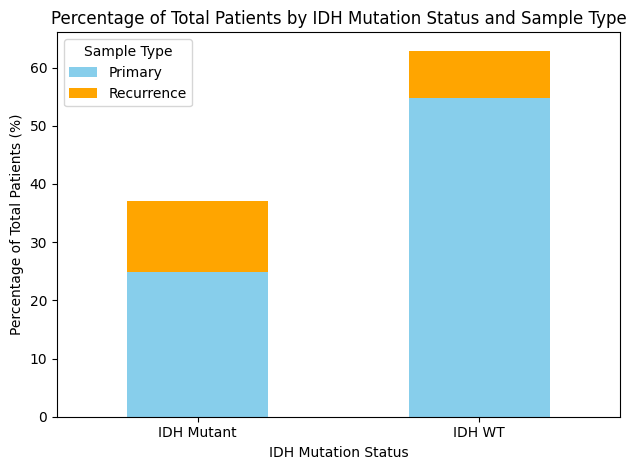

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Group by 'Patient ID' and keep the first sample for each patient
patients_df = merged_df_clean.groupby('Patient ID').first().reset_index()

# Step 2: Identify IDH mutant patients (those with IDH1 or IDH2 mutations)
idh_mutant_patients = merged_df_clean[merged_df_clean['Hugo_Symbol'].isin(['IDH1', 'IDH2'])]['Patient ID'].unique()

# Step 3: Assign IDH Status to each patient based on 'Patient ID'
patients_df['IDH_Status'] = patients_df['Patient ID'].apply(
    lambda pid: 'IDH Mutant' if pid in idh_mutant_patients else 'IDH WT'
)

# Step 4: Group by 'IDH_Status' and 'Sample Type' and count the number of patients
grouped_counts = patients_df.groupby(['IDH_Status', 'Sample Type']).size().unstack(fill_value=0)

# Step 5: Calculate the percentage of patients relative to the total number of patients in the dataset
total_patients = patients_df['Patient ID'].nunique()
grouped_percentage = grouped_counts.div(total_patients) * 100

# Step 6: Ensure the correct order of 'Sample Type' (Primary first, Recurrence second)
grouped_percentage = grouped_percentage[['Primary', 'Recurrence']]

# Step 7: Create a stacked bar plot with the percentage of total patients on the Y-axis
grouped_percentage.plot(kind='bar', stacked=True, color=['skyblue', 'orange'])

# Step 8: Customize the plot labels and formatting
plt.title('Percentage of Total Patients by IDH Mutation Status and Sample Type')
plt.xlabel('IDH Mutation Status')
plt.ylabel('Percentage of Total Patients (%)')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(title='Sample Type')
plt.tight_layout()

# Step 9: Show the plot
plt.show()


P-values: {'Primary': 1.659953987802262e-147, 'Recurrence': 7.581727399256121e-39}


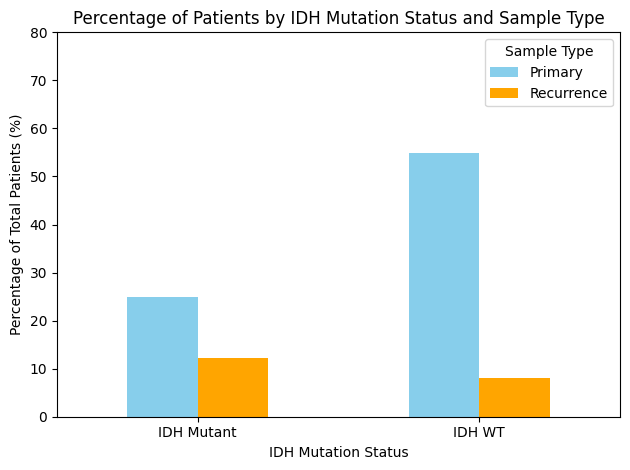

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Step 1: Group by 'Patient ID' and keep the first sample for each patient
patients_df = merged_df_clean.groupby('Patient ID').first().reset_index()

# Step 2: Identify IDH mutant patients
idh_mutant_patients = merged_df_clean[merged_df_clean['Hugo_Symbol'].isin(['IDH1', 'IDH2'])]['Patient ID'].unique()

# Step 3: Assign IDH Status
patients_df['IDH_Status'] = patients_df['Patient ID'].apply(
    lambda pid: 'IDH Mutant' if pid in idh_mutant_patients else 'IDH WT'
)

# Step 4: Group by 'IDH_Status' and 'Sample Type' to count patients
grouped_counts = patients_df.groupby(['IDH_Status', 'Sample Type']).size().unstack(fill_value=0)

# Step 5: Calculate the percentage of patients
total_patients = patients_df['Patient ID'].nunique()
grouped_percentage = grouped_counts.div(total_patients) * 100

# Step 6: Ensure correct order of 'Sample Type'
grouped_percentage = grouped_percentage[['Primary', 'Recurrence']]

# Step 7: Create a bar plot
ax = grouped_percentage.plot(kind='bar', stacked=False, color=['skyblue', 'orange'])

# Step 8: Prepare for Mann-Whitney U tests
p_values = {}
sample_types = ['Primary', 'Recurrence']

# Step 9: Mann-Whitney U tests for each sample type
for sample in sample_types:
    group_mutant = [grouped_counts.loc['IDH Mutant', sample]] * grouped_counts.loc['IDH Mutant', sample]
    group_wt = [grouped_counts.loc['IDH WT', sample]] * grouped_counts.loc['IDH WT', sample]

    # Perform the Mann-Whitney U test
    stat, p_value = mannwhitneyu(group_mutant, group_wt, alternative='two-sided')
    p_values[sample] = p_value

# Debug: Print p-values
print("P-values:", p_values)

# Step 10: Customize the plot
plt.title('Percentage of Patients by IDH Mutation Status and Sample Type')
plt.xlabel('IDH Mutation Status')
plt.ylabel('Percentage of Total Patients (%)')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(title='Sample Type')

# Add p-values to the legend
p_values_text = [f"{sample}: {p_values[sample]:.2e}" for sample in sample_types]
plt.legend(title='Sample Type', labels=['Primary', 'Recurrence'] + p_values_text)

plt.ylim(0, 80)  # Adjust the y-axis limit
plt.tight_layout()

# Step 11: Show the plot
plt.show()


P-values: {'Primary': 1.659953987802262e-147, 'Recurrence': 7.581727399256121e-39}


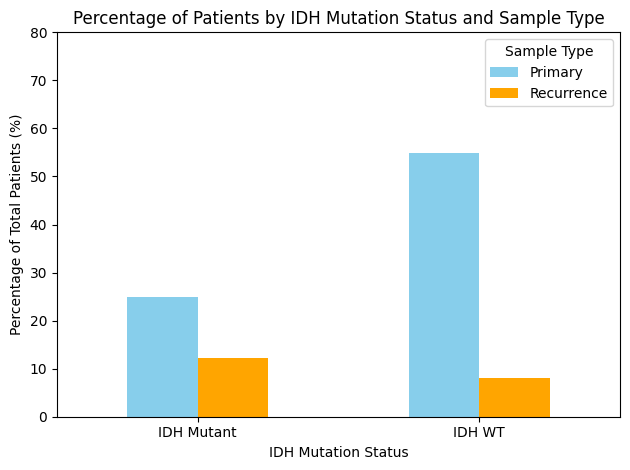

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Step 1: Group by 'Patient ID' and keep the first sample for each patient
patients_df = merged_df_clean.groupby('Patient ID').first().reset_index()

# Step 2: Identify IDH mutant patients
idh_mutant_patients = merged_df_clean[merged_df_clean['Hugo_Symbol'].isin(['IDH1', 'IDH2'])]['Patient ID'].unique()

# Step 3: Assign IDH Status
patients_df['IDH_Status'] = patients_df['Patient ID'].apply(
    lambda pid: 'IDH Mutant' if pid in idh_mutant_patients else 'IDH WT'
)

# Step 4: Group by 'IDH_Status' and 'Sample Type' to count patients
grouped_counts = patients_df.groupby(['IDH_Status', 'Sample Type']).size().unstack(fill_value=0)

# Step 5: Calculate the percentage of patients
total_patients = patients_df['Patient ID'].nunique()
grouped_percentage = grouped_counts.div(total_patients) * 100

# Step 6: Ensure correct order of 'Sample Type'
grouped_percentage = grouped_percentage[['Primary', 'Recurrence']]

# Step 7: Create a bar plot
ax = grouped_percentage.plot(kind='bar', stacked=False, color=['skyblue', 'orange'])

# Step 8: Prepare for Mann-Whitney U tests
p_values = {}
sample_types = ['Primary', 'Recurrence']

# Step 9: Mann-Whitney U tests for each sample type
for sample in sample_types:
    group_mutant = [grouped_counts.loc['IDH Mutant', sample]] * grouped_counts.loc['IDH Mutant', sample]
    group_wt = [grouped_counts.loc['IDH WT', sample]] * grouped_counts.loc['IDH WT', sample]

    # Perform the Mann-Whitney U test
    stat, p_value = mannwhitneyu(group_mutant, group_wt, alternative='two-sided')
    p_values[sample] = p_value

# Debug: Print p-values
print("P-values:", p_values)

# Step 10: Customize the plot
plt.title('Percentage of Patients by IDH Mutation Status and Sample Type')
plt.xlabel('IDH Mutation Status')
plt.ylabel('Percentage of Total Patients (%)')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(title='Sample Type')

# Add p-values to the legend
p_values_text = [f"{sample}: {p_values[sample]:.2e}" for sample in sample_types]
plt.legend(title='Sample Type', labels=['Primary', 'Recurrence'] + p_values_text)

plt.ylim(0, 80)  # Adjust the y-axis limit
plt.tight_layout()

# Step 11: Show the plot
plt.show()


<ipython-input-118-8c9909eb3e70>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['WHO Grade Grouped'] = filtered_df['WHO Grade'].replace({
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


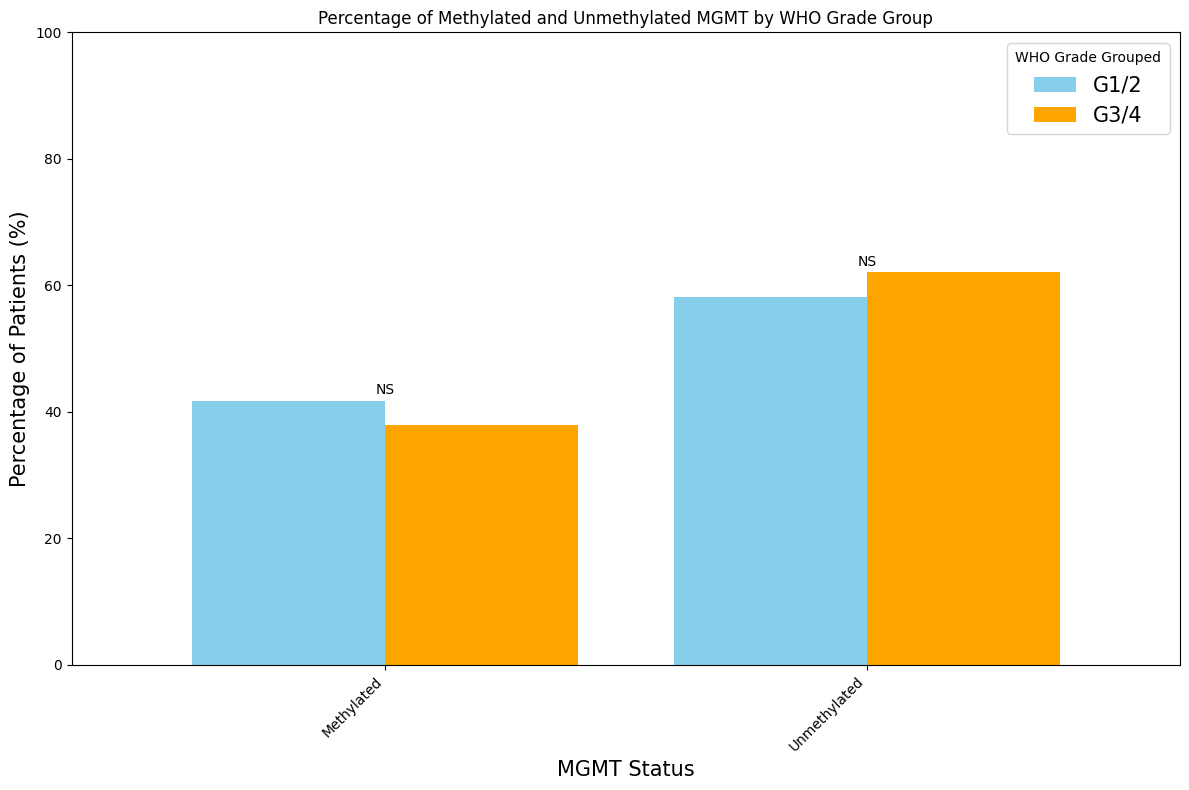

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Step 1: Filter out 'Indeterminate' from the WHO Grade column and group WHO Grades
filtered_df = merged_df_clean[merged_df_clean['WHO Grade'] != 'Indeterminate']
filtered_df['WHO Grade Grouped'] = filtered_df['WHO Grade'].replace({
    'G1': 'G1/2',
    'G1/G2': 'G1/2',
    'G2': 'G1/2',
    'G3': 'G3/4',
    'G3/G4': 'G3/4',
    'G4': 'G3/4'
})

# Step 2: Count unique patients in each MGMT status and WHO Grade Grouped
mgmt_counts = filtered_df.groupby(['MGMT Status', 'WHO Grade Grouped'])['Patient ID'].nunique().unstack(fill_value=0)

# Step 3: Calculate the percentage of patients in each group
total_patients = mgmt_counts.sum(axis=0)
mgmt_perc = mgmt_counts.div(total_patients, axis=1) * 100

# Step 4: Perform t-tests to compare the distributions
t_test_results = {}
for mgmt_status in mgmt_counts.index:
    g1_2_count = mgmt_counts.loc[mgmt_status, 'G1/2']
    g3_4_count = mgmt_counts.loc[mgmt_status, 'G3/4']

    # Prepare lists for t-test
    g1_2_data = [1] * g1_2_count
    g3_4_data = [1] * g3_4_count

    # Perform t-test if both groups have data
    if g1_2_count > 0 and g3_4_count > 0:
        t_stat, p_value = ttest_ind(g1_2_data, g3_4_data, equal_var=False)
        t_test_results[mgmt_status] = p_value
    else:
        t_test_results[mgmt_status] = float('nan')  # Use NaN for missing data

# Step 5: Plot the data
ax = mgmt_perc.plot(kind='bar', figsize=(12, 8), width=0.8,['skyblue', 'orange'] )

# Step 6: Customize the plot
ax.set_ylabel('Percentage of Patients (%)', fontsize=15)
ax.set_xlabel('MGMT Status', fontsize=15)
ax.set_title('Percentage of Methylated and Unmethylated MGMT by WHO Grade Group')
plt.xticks(rotation=45, ha='right')
ax.legend(title='WHO Grade Grouped', fontsize=15)

# Step 7: Set y-axis to be percentage scale (0 to 100)
ax.set_ylim(0, 100)

# Step 8: Annotate the plot with p-values
for i, mgmt_status in enumerate(mgmt_counts.index):
    p = t_test_results.get(mgmt_status, float('nan'))

    # Define the position for the annotation
    y_position = mgmt_perc.loc[mgmt_status].max() + 1

    # Add text based on p-value
    if pd.isna(p) or p >= 0.05:
        ax.text(i, y_position, 'NS', ha='center', color='black', fontsize=10)
    elif p < 0.001:
        ax.text(i, y_position + 3, '***', ha='center', color='black', fontsize=10)
    elif p < 0.01:
        ax.text(i, y_position + 2, '**', ha='center', color='black', fontsize=10)
    elif p < 0.05:
        ax.text(i, y_position + 1, '*', ha='center', color='black', fontsize=10)

# Step 9: Display the plot
plt.tight_layout()
plt.show()


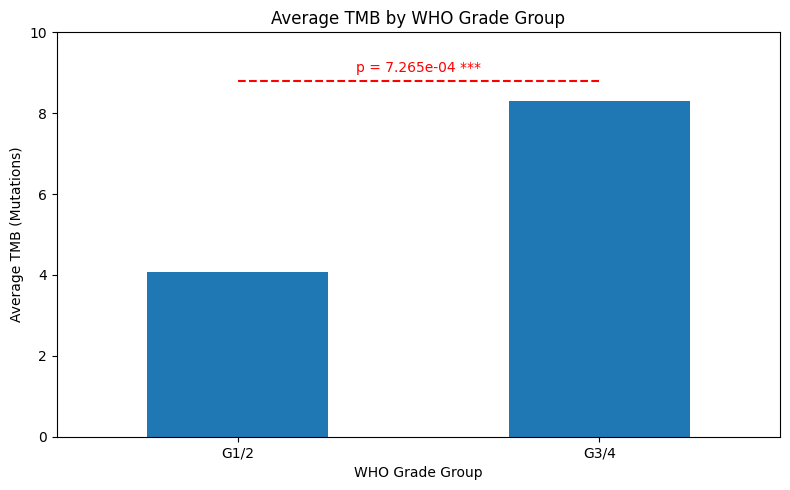

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Sample data creation (Replace this with your actual merged_df_clean)
# merged_df_clean = pd.read_csv('path_to_your_data.csv')

# Step 1: Group by 'Patient ID' and keep the first sample for each patient
patients_df = merged_df_clean.groupby('Patient ID').first().reset_index()

# Step 2: Filter out 'Indeterminate' values
filtered_df = patients_df[patients_df['WHO Grade'] != 'Indeterminate'].copy()

# Step 3: Create a new column for grouped WHO Grades
filtered_df['WHO Grade Grouped'] = filtered_df['WHO Grade'].replace({
    'G1': 'G1/2',
    'G1/G2': 'G1/2',
    'G2': 'G1/2',
    'G3': 'G3/4',
    'G3/G4': 'G3/4',
    'G4': 'G3/4'
})

# Step 4: Calculate average TMB for each group
average_tmb = filtered_df.groupby('WHO Grade Grouped')['TMB (nonsynonymous)'].mean().reset_index()

# Step 5: Perform t-test between G1/2 and G3/4
g1_2_tmb = filtered_df[filtered_df['WHO Grade Grouped'] == 'G1/2']['TMB (nonsynonymous)']
g3_4_tmb = filtered_df[filtered_df['WHO Grade Grouped'] == 'G3/4']['TMB (nonsynonymous)']

t_stat, p_value = ttest_ind(g1_2_tmb, g3_4_tmb, equal_var=False)

# Step 6: Prepare for plotting
ax = average_tmb.plot(kind='bar', x='WHO Grade Grouped', y='TMB (nonsynonymous)', figsize=(8, 5), legend=False)

# Step 7: Customize the plot
ax.set_ylabel('Average TMB (Mutations)')
ax.set_xlabel('WHO Grade Group')
ax.set_title('Average TMB by WHO Grade Group')
ax.set_ylim(0, 10)  # Set y-axis limit to 10
plt.xticks(rotation=0)

# Step 8: Annotate the plot with p-value significance
if p_value < 0.001:
    significance = '***'
elif p_value < 0.01:
    significance = '**'
elif p_value < 0.05:
    significance = '*'
else:
    significance = 'NS'

# Calculate the position for the p-value line
x_pos = 0.5  # Position for the line between bars
y_pos = max(average_tmb['TMB (nonsynonymous)']) + 0.5  # Position slightly above the bars

# Add the line for p-value
ax.hlines(y=y_pos, xmin=0, xmax=1, color='red', linestyle='--')

# Add the p-value text above the line
ax.text(x_pos, y_pos + 0.2, f'p = {p_value:.3e} {significance}', ha='center', color='red')

# Step 9: Display the plot
plt.tight_layout()
plt.show()


<ipython-input-161-b7052d913ead>:51: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  '*' * (p < 0.05) +
<ipython-input-161-b7052d913ead>:52: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  '**' * (p < 0.01) +
<ipython-input-161-b7052d913ead>:53: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  '***' * (p < 0.001),


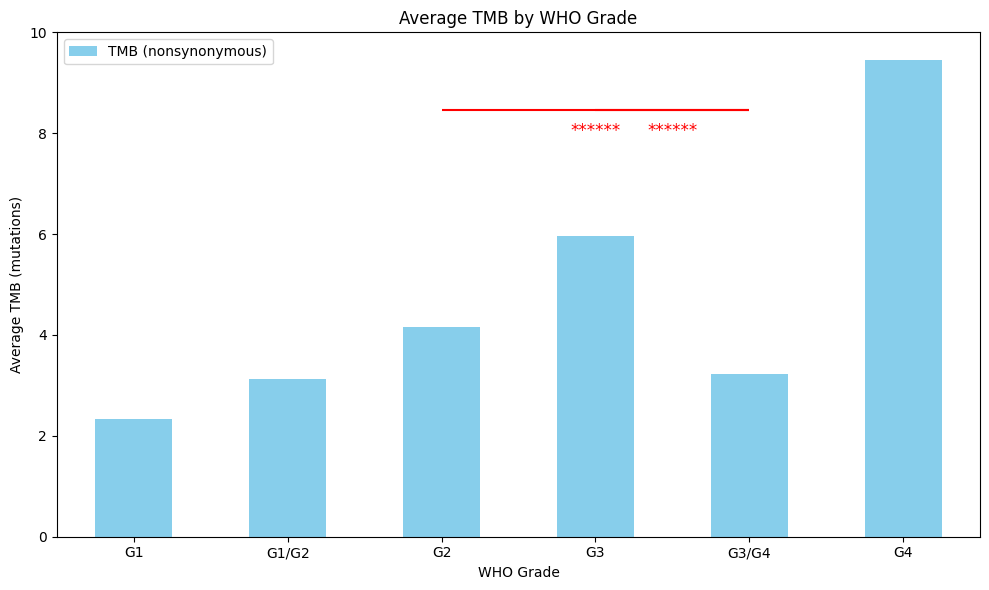

Significant Pairwise P-values: {'G2 vs G3/G4': -0.9241, 'G3 vs G3/G4': -2.7352}


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Step 1: Filter out 'Indeterminate' values and keep one patient per Patient ID
filtered_df = merged_df_clean[merged_df_clean['WHO Grade'] != 'Indeterminate']
patients_df = filtered_df.groupby('Patient ID').first().reset_index()

# Step 2: Calculate the average TMB for each WHO Grade
average_tmb = patients_df.groupby('WHO Grade')['TMB (nonsynonymous)'].mean().reset_index()

# Step 3: Perform Kruskal-Wallis H-test for initial comparison
h_stat, p_value = kruskal(
    *[group['TMB (nonsynonymous)'].values for name, group in patients_df.groupby('WHO Grade')]
)

# Step 4: Perform pairwise comparisons using Tukey's HSD
tukey_results = pairwise_tukeyhsd(endog=patients_df['TMB (nonsynonymous)'],
                                   groups=patients_df['WHO Grade'],
                                   alpha=0.05)

# Extract p-values for pairwise comparisons
pairwise_p_values = {}
for comparison in tukey_results.summary().data[1:]:
    grade1, grade2, p_val, reject = comparison[0], comparison[1], comparison[2], comparison[3]
    if p_val < 0.05:  # Only keep significant p-values
        pairwise_p_values[f'{grade1} vs {grade2}'] = p_val

# Step 5: Plot the data
ax = average_tmb.plot(kind='bar', x='WHO Grade', y='TMB (nonsynonymous)',
                       figsize=(10, 6), ylim=(0, 10), color='skyblue')

# Step 6: Customize the plot
ax.set_ylabel('Average TMB (mutations)')
ax.set_title('Average TMB by WHO Grade')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal

# Step 7: Annotate the plot with significant p-values and connect bars
for comparison, p in pairwise_p_values.items():
    grade1, grade2 = comparison.split(' vs ')
    x1 = average_tmb[average_tmb['WHO Grade'] == grade1].index[0]
    x2 = average_tmb[average_tmb['WHO Grade'] == grade2].index[0]

    # Position for the p-value line
    y_position = max(average_tmb['TMB (nonsynonymous)']) - 1  # Lower the p-value line
    ax.hlines(y=y_position, xmin=x1, xmax=x2, color='red')

    # Add p-value annotation below the line
    ax.text((x1 + x2) / 2, y_position - 0.5,
            '*' * (p < 0.05) +
            '**' * (p < 0.01) +
            '***' * (p < 0.001),
            ha='center', color='red', fontsize=12)

# Step 8: Show the plot
plt.tight_layout()
plt.show()

# Print the significant pairwise p-values
print("Significant Pairwise P-values:", pairwise_p_values)


**Let's calculate the percentage of patients with mutations in different pre-defined pathways**

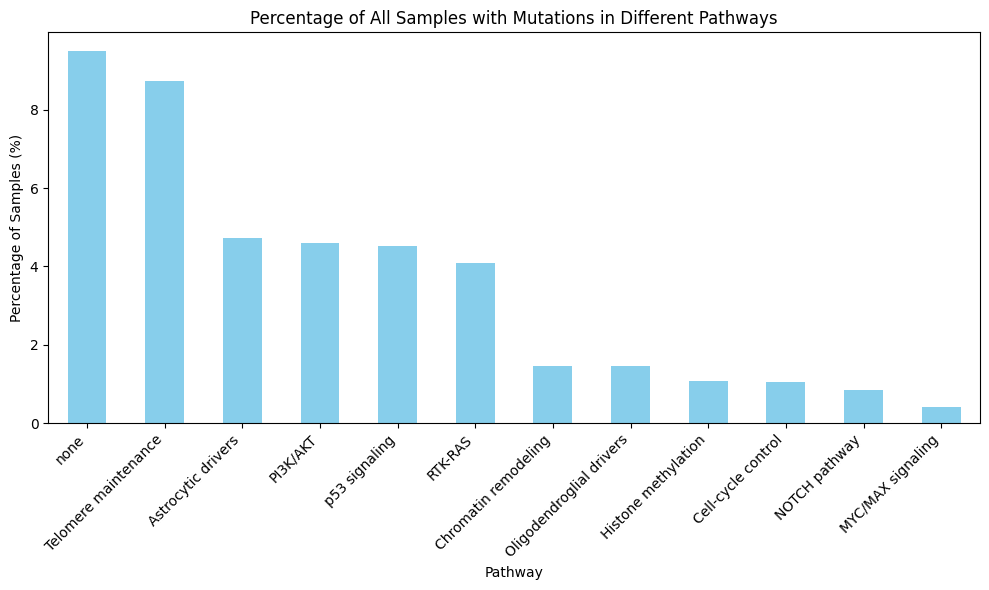

In [ ]:
# Step 1: Count the total number of samples (regardless of IDH status)
total_samples = len(merged_df_clean)

# Step 2: Group by Pathway and count the number of unique samples for each pathway
pathway_counts = merged_df_clean.groupby('Pathway')['Tumor_Sample_Barcode'].nunique()

# Step 3: Calculate the percentage of samples in each pathway
pathway_percentages = (pathway_counts / total_samples) * 100

# Step 4: Sort pathways by percentage for better visualization (optional)
pathway_percentages = pathway_percentages.sort_values(ascending=False)

# Step 5: Plot the percentages using a bar plot
plt.figure(figsize=(10, 6))
pathway_percentages.plot(kind='bar', color='skyblue')

# Step 6: Customize the plot
plt.title('Percentage of All Samples with Mutations in Different Pathways')
plt.xlabel('Pathway')
plt.ylabel('Percentage of Samples (%)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()

# Step 7: Show the plot
plt.show()

In [ ]:
p

1.0

Divid samples to the WHO classes 1/2 and 3/4, and do the chi-2 test to see, which differences between groups are significant

<ipython-input-35-7312c8794993>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['WHO Grade Grouped'] = filtered_df['WHO Grade'].replace({


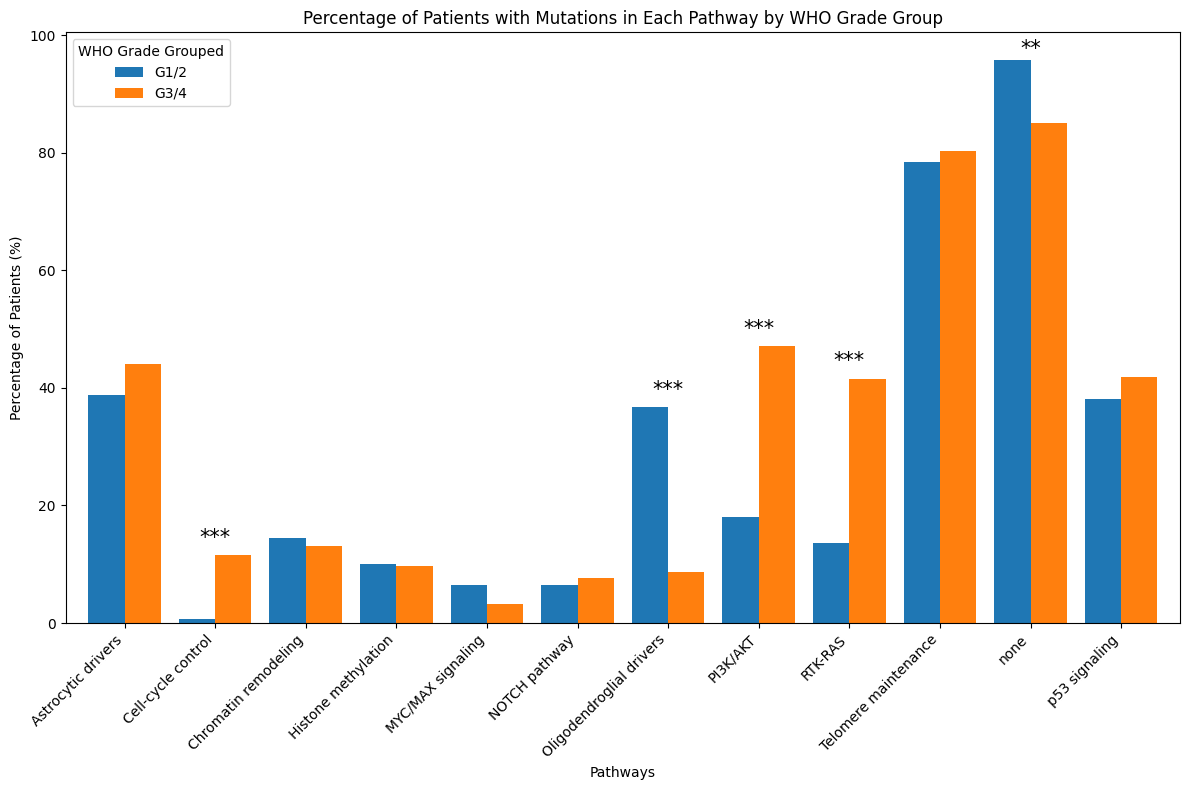

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Step 1: Create a new column for grouped WHO Grades
filtered_df['WHO Grade Grouped'] = filtered_df['WHO Grade'].replace({
    'G1': 'G1/2',
    'G1/G2': 'G1/2',
    'G2': 'G1/2',
    'G3': 'G3/4',
    'G3/G4': 'G3/4',
    'G4': 'G3/4'
})
# Step 2: Count unique patients in each pathway and WHO grade group
pathway_counts = filtered_df.groupby(['Pathway', 'WHO Grade Grouped'])['Patient ID'].nunique().unstack()

# Step 3: Calculate the total number of patients for each WHO group
total_patients_per_who_group = filtered_df.groupby('WHO Grade Grouped')['Patient ID'].nunique()

# Step 4: Calculate the percentage of patients in each pathway within each WHO grade group
pathway_perc_within_who = pathway_counts.div(total_patients_per_who_group, axis=1) * 100

# Initialize a dictionary to store p-values
p_values = {}

# Step 5: Perform chi-square test for each pathway between G1/2 and G3/4
for pathway in pathway_counts.index:
    # Extract counts for the pathway in G1/2 and G3/4 groups
    counts = pathway_counts.loc[pathway]

    # Check if there are non-zero values in both G1/2 and G3/4 groups
    if not counts.isnull().values.any():  # Ensure there are no NaN values
        # Construct contingency table for chi-square test
        contingency_table = [
            [counts['G1/2'], total_patients_per_who_group['G1/2'] - counts['G1/2']],
            [counts['G3/4'], total_patients_per_who_group['G3/4'] - counts['G3/4']]
        ]

        # Perform chi-square test
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Store the p-value
        p_values[pathway] = p
    else:
        p_values[pathway] = 1.0  # Assign a p-value of 1.0 if there are missing values

# Step 6: Plot the data
ax = pathway_perc_within_who.plot(kind='bar', stacked=False, figsize=(12, 8), width=0.8)

# Step 7: Customize the plot
ax.set_ylabel('Percentage of Patients (%)')
ax.set_xlabel('Pathways')
ax.set_title('Percentage of Patients with Mutations in Each Pathway by WHO Grade Group')
plt.xticks(rotation=45, ha='right')

# Add legend
ax.legend(title='WHO Grade Grouped')

# Step 8: Annotate the plot with significant p-values
for i, pathway in enumerate(pathway_counts.index):
    p = p_values[pathway]

    # If p-value is significant, add stars to the plot (only once)
    if p < 0.001:
        ax.text(i, max(pathway_perc_within_who.loc[pathway]) + 2, '***', ha='center', color='black', fontsize=15)
    elif p < 0.01:
        ax.text(i, max(pathway_perc_within_who.loc[pathway]) + 1, '**', ha='center', color='black', fontsize=15)
    elif p < 0.05:
        ax.text(i, max(pathway_perc_within_who.loc[pathway]), '*', ha='center', color='black', fontsize=15)

# Display the plot
plt.tight_layout()
plt.show()


**Survival plots**

In [26]:
import pandas as pd

# Step 1: Filter out missing survival data
cleaned_df = merged_df_clean.dropna(subset=['Overall Survival (Months)', 'Overall Survival Status'])

# Step 2: Ensure unique patients by selecting the first sample per patient
unique_patients_df = cleaned_df.groupby('Patient ID').first().reset_index()

# Step 3: Check for missing values in the necessary columns
missing_values = unique_patients_df[['Pathway', 'Overall Survival (Months)', 'Overall Survival Status']].isnull().sum()

# Step 4: Display if any columns have missing values and need further cleaning
print("Missing values in relevant columns:\n", missing_values)

# Step 5: Preview the data to ensure it's ready for survival analysis
print("Preview of cleaned data:\n", unique_patients_df[['Patient ID', 'Pathway', 'Overall Survival (Months)', 'Overall Survival Status']].head())


Missing values in relevant columns:
 Pathway                      0
Overall Survival (Months)    0
Overall Survival Status      0
dtype: int64
Preview of cleaned data:
   Patient ID               Pathway  Overall Survival (Months)  \
0  P-0000223    Astrocytic drivers                     161.00   
1  P-0000378               RTK-RAS                      36.60   
2  P-0000486  Chromatin remodeling                     113.00   
3  P-0000500                  none                      52.60   
4  P-0000572  Chromatin remodeling                       5.52   

  Overall Survival Status  
0              1:DECEASED  
1              1:DECEASED  
2                0:LIVING  
3              1:DECEASED  
4              1:DECEASED  


In [28]:
# Step 1: Clean the 'Overall Survival Status' to be binary (1 for deceased, 0 for living)
unique_patients_df['event_observed'] = unique_patients_df['Overall Survival Status'].apply(
    lambda x: 1 if 'DECEASED' in x else 0
)

# Step 2: Preview the cleaned data
print(unique_patients_df[['Patient ID', 'Pathway', 'Overall Survival (Months)', 'event_observed']].head())

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 7.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=941656840d9d8d3106918dd3568ef90ceace1d28832ee1405206423a4dcb27f1
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Patient ID               Pathway  Overall Survival (Months)  event_observed
0  P-0000223    Astrocytic drivers                     161.00               1
1  P-0000378               RTK-RAS                      36.60               1
2  P-0000486  Chromatin remodeling                     113.00               0
3  P-0000500                  none                      52.60               1
4  P-0000572  Chromatin remodeling                       5.52               1


<ipython-input-84-02349354af51>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['event_observed'] = filtered_df['Overall Survival Status'].apply(


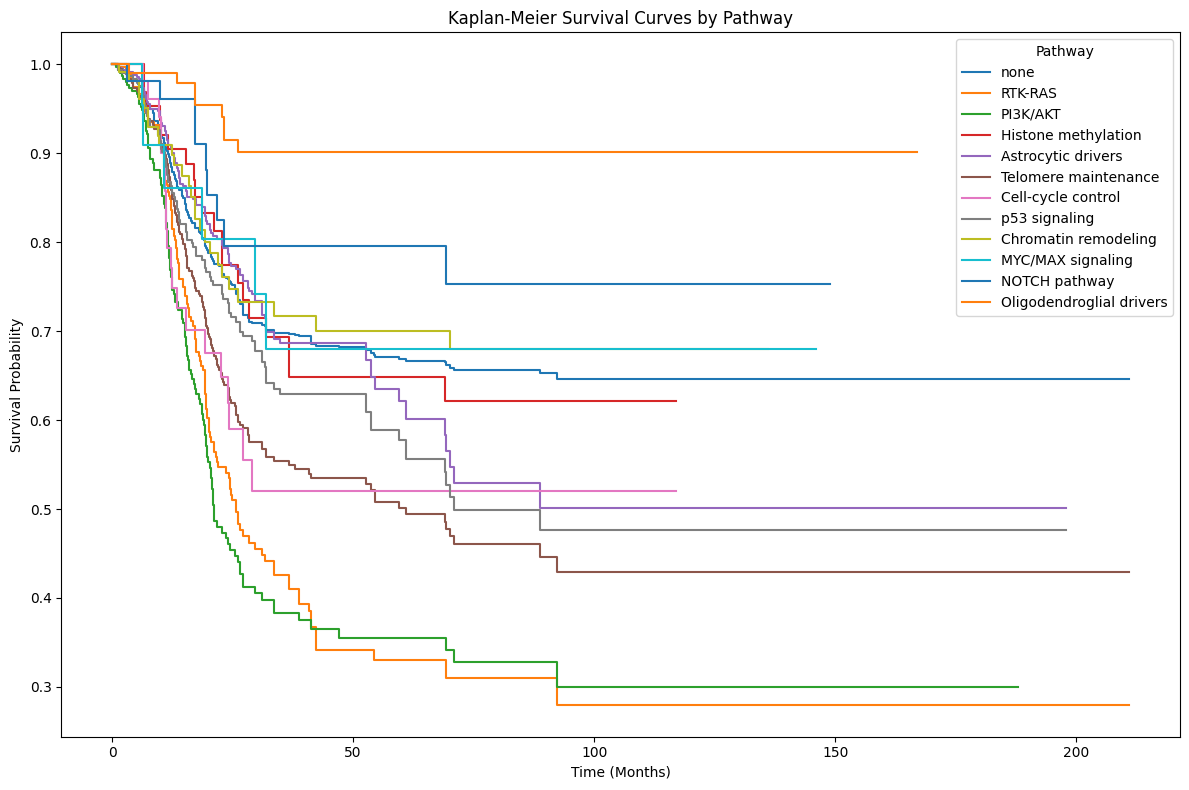

Significant Pairwise P-values:


AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test

# Step 1: Filter to only keep samples with 'Primary' in the 'Sample Type' column
filtered_df = merged_df_clean[merged_df_clean['Sample Type'] == 'Primary']

# Debugging: Check if the filtered dataframe is empty
if filtered_df.empty:
    raise ValueError("Filtered dataframe is empty after filtering by 'Primary' Sample Type.")

# Step 2: Clean the 'Overall Survival Status' to make it binary (1 for deceased, 0 for living)
filtered_df['event_observed'] = filtered_df['Overall Survival Status'].apply(
    lambda x: 1 if 'DECEASED' in x else 0
)

# Debugging: Check for NaN values in survival columns
if filtered_df['Overall Survival (Months)'].isnull().sum() > 0:
    raise ValueError("There are NaN values in 'Overall Survival (Months)'. Please clean the data.")
if filtered_df['event_observed'].isnull().sum() > 0:
    raise ValueError("There are NaN values in 'event_observed'. Please clean the data.")

# Step 3: Group patients by Pathway
pathways = filtered_df['Pathway'].unique()

# Debugging: Check if pathways exist
if len(pathways) == 0:
    raise ValueError("No pathways found in the dataset after filtering.")

# Step 4: Initialize the Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Step 5: Plot Kaplan-Meier survival curves comparing between pathways (without confidence intervals)
plt.figure(figsize=(12, 8))

for pathway in pathways:
    pathway_data = filtered_df[filtered_df['Pathway'] == pathway]

    # Debugging: Check if there's enough data in each pathway
    if pathway_data.empty:
        print(f"Skipping {pathway}: No data for this pathway.")
        continue

    if pathway_data['Overall Survival (Months)'].nunique() < 2:
        print(f"Skipping {pathway}: Not enough unique survival data points for this pathway.")
        continue

    # Fit the Kaplan-Meier model for each pathway
    kmf.fit(pathway_data['Overall Survival (Months)'], event_observed=pathway_data['event_observed'], label=pathway)
    kmf.plot_survival_function(ci_show=False)  # Remove confidence intervals

# Customize the plot
plt.title('Kaplan-Meier Survival Curves by Pathway')
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.legend(title='Pathway', loc='best')
plt.tight_layout()

# Step 6: Perform log-rank tests to compare survival curves between pathways
pairwise_results = pairwise_logrank_test(
    filtered_df['Overall Survival (Months)'],
    groups=filtered_df['Pathway'],
    event_observed=filtered_df['event_observed']
)

# Step 7: Display the plot
plt.show()

# Print significant pairwise p-values
print("Significant Pairwise P-values:")
for comparison, p_value in pairwise_results.p_value.items():
    if p_value < 0.05:
        print(f'Log-rank test between {comparison[0]} and {comparison[1]}: p-value = {p_value}')


<ipython-input-85-39bd95bb6490>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_df['event_observed'] = primary_df['Overall Survival Status'].apply(lambda x: 1 if 'DECEASED' in x else 0)


AttributeError: 'StatisticalResult' object has no attribute '_multitest_comparisons'

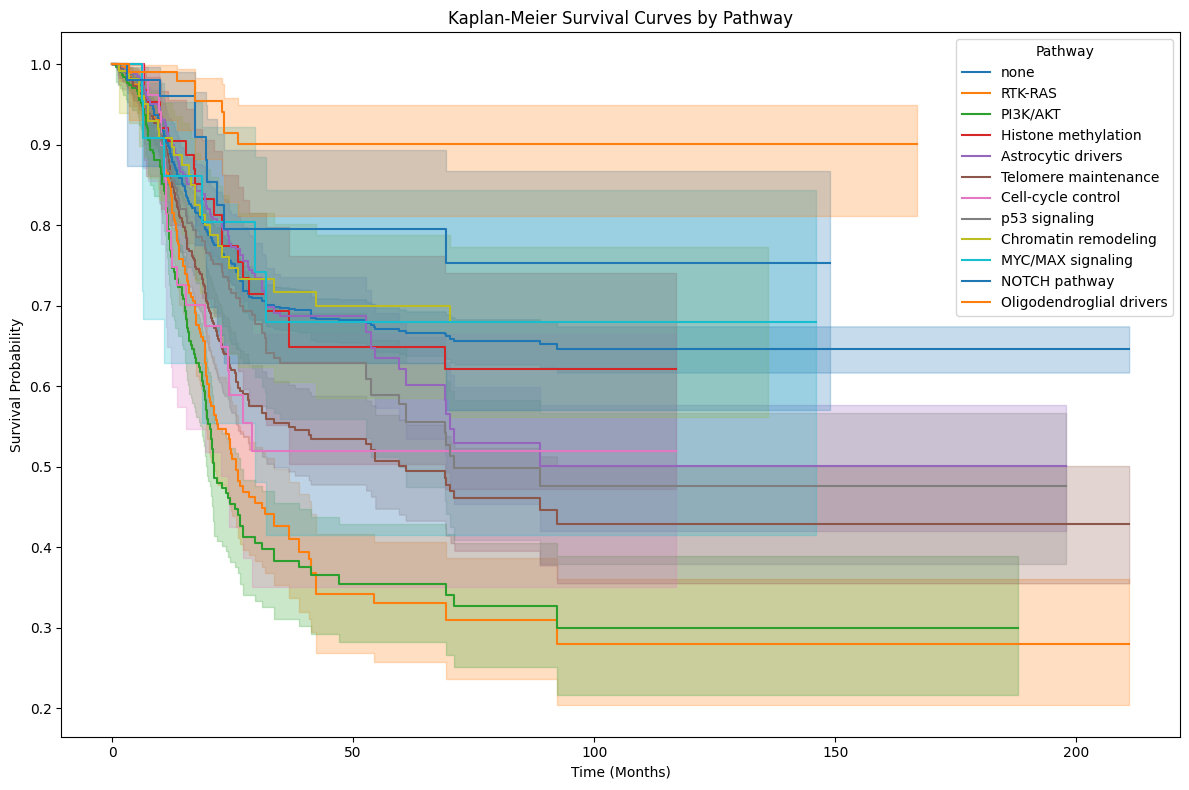

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test

# Step 1: Filter for Primary samples only
primary_df = merged_df_clean[merged_df_clean['Sample Type'] == 'Primary']

# Step 2: Clean the 'Overall Survival Status' to binary
primary_df['event_observed'] = primary_df['Overall Survival Status'].apply(lambda x: 1 if 'DECEASED' in x else 0)

# Step 3: Get all unique pathways
pathways = primary_df['Pathway'].unique()

# Step 4: Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Step 5: Plot Kaplan-Meier curves for each pathway
plt.figure(figsize=(12, 8))
for pathway in pathways:
    pathway_data = primary_df[primary_df['Pathway'] == pathway]
    kmf.fit(pathway_data['Overall Survival (Months)'], event_observed=pathway_data['event_observed'], label=pathway)
    kmf.plot_survival_function()

# Customize the plot
plt.title('Kaplan-Meier Survival Curves by Pathway')
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.legend(title='Pathway', loc='best')
plt.tight_layout()

# Step 6: Perform pairwise log-rank tests
pairwise_results = pairwise_logrank_test(primary_df['Overall Survival (Months)'],
                                         groups=primary_df['Pathway'],
                                         event_observed=primary_df['event_observed'])

# Step 7: Print significant pairwise p-values
p_values = pairwise_results.p_value
comparisons = pairwise_results._multitest_comparisons

print("Significant Pairwise P-values:")
for i, (comparison_1, comparison_2) in enumerate(comparisons):
    p_value = p_values[i]
    if p_value < 0.05:
        print(f'Log-rank test between {comparison_1} and {comparison_2}: p-value = {p_value}')

# Step 8: Show the plot
plt.show()


In [86]:
primary_df

,Hugo_Symbol,Entrez_Gene_Id,Consequence,Tumor_Sample_Barcode,HGVSp_Short,Hotspot,Pathway,Study ID,Patient ID,Sample ID,...,Progress Free Survival (Months),Progression Free Status,Number of Samples Per Patient,Sample Type,Sex,TMB (nonsynonymous),WHO Classification of Diagnostic Tumor,WHO Grade,IDH Status,event_observed
8,DICER1,23405.0,missense_variant,P-0003850-T01-IM5,p.I1043T,0,none,glioma_mskcc_2019,P-0003850,P-0003850-T01-IM5,...,10.60,1:PROGRESSION,1.0,Primary,Male,2.936159,"Glioblastoma, IDH-wildtype",G4,IDH WT,1
9,EGFR,1956.0,missense_variant,P-0003850-T01-IM5,p.R222C,0,RTK-RAS,glioma_mskcc_2019,P-0003850,P-0003850-T01-IM5,...,10.60,1:PROGRESSION,1.0,Primary,Male,2.936159,"Glioblastoma, IDH-wildtype",G4,IDH WT,1
10,RASA1,5921.0,missense_variant,P-0003850-T01-IM5,p.E333Q,0,none,glioma_mskcc_2019,P-0003850,P-0003850-T01-IM5,...,10.60,1:PROGRESSION,1.0,Primary,Male,2.936159,"Glioblastoma, IDH-wildtype",G4,IDH WT,1
11,HRAS,3265.0,missense_variant,P-0005696-T01-IM5,p.Q61L,0,RTK-RAS,glioma_mskcc_2019,P-0005696,P-0005696-T01-IM5,...,6.08,1:PROGRESSION,1.0,Primary,Male,5.872318,"Glioblastoma, IDH-wildtype",G4,IDH WT,1
12,NOTCH4,4855.0,missense_variant,P-0005696-T01-IM5,p.G148E,0,none,glioma_mskcc_2019,P-0005696,P-0005696-T01-IM5,...,6.08,1:PROGRESSION,1.0,Primary,Male,5.872318,"Glioblastoma, IDH-wildtype",G4,IDH WT,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9666,TERT,7015.0,upstream_gene_variant,P-0003079-T01-IM5,NaN,0,Telomere maintenance,glioma_mskcc_2019,P-0003079,P-0003079-T01-IM5,...,NaN,NaN,1.0,Primary,Male,1.957439,"Glioblastoma, IDH-wildtype",G4,IDH WT,1
9667,TERT,7015.0,upstream_gene_variant,TRF056398,NaN,0,Telomere maintenance,glioma_mskcc_2019,TRF056398,TRF056398,...,7.96,1:PROGRESSION,1.0,Primary,Male,5.008339,"Glioblastoma, IDH-wildtype",G4,IDH WT,1
9668,TERT,7015.0,upstream_gene_variant,P-0002452-T01-IM3,NaN,0,Telomere maintenance,glioma_mskcc_2019,P-0002452,P-0002452-T01-IM3,...,6.28,1:PROGRESSION,1.0,Primary,Female,2.218311,"Glioblastoma, IDH-wildtype",G4,IDH WT,1
9669,TERT,7015.0,upstream_gene_variant,P-0004609-T01-IM5,NaN,0,Telomere maintenance,glioma_mskcc_2019,P-0004609,P-0004609-T01-IM5,...,NaN,NaN,1.0,Primary,Male,3.914879,"Glioblastoma, IDH-wildtype",G4,IDH WT,1


**Survival plots for IDH WT and Mutant**

<ipython-input-76-0f0a4af36a41>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_clean['event_observed'] = merged_df_clean['Overall Survival Status'].apply(
<ipython-input-76-0f0a4af36a41>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['IDH Status'] = cleaned_df['Patient ID'].apply(


Log-rank test p-value between IDH Mutant and IDH WT for none: 0.0


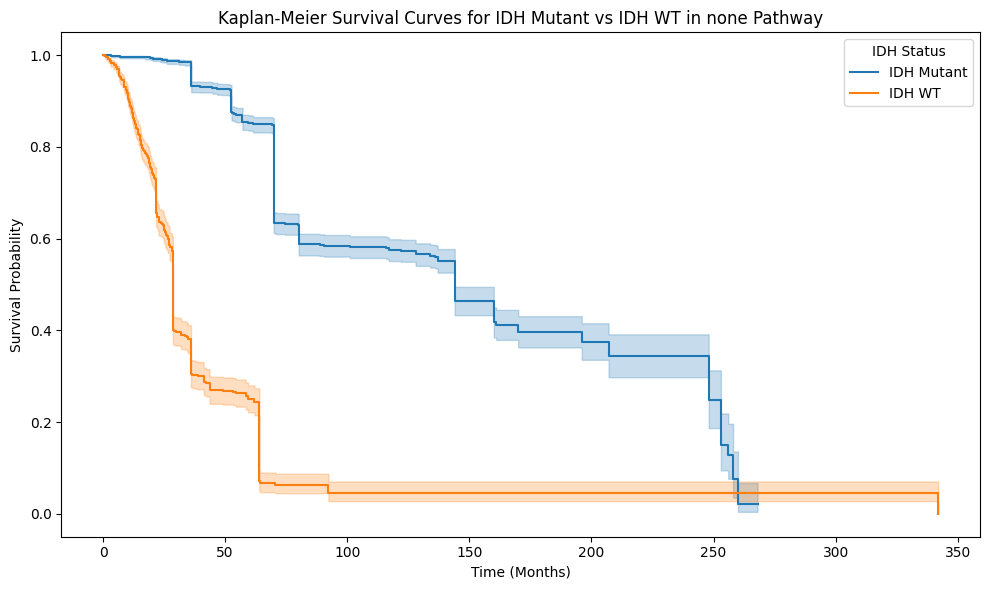

Log-rank test p-value between IDH Mutant and IDH WT for RTK-RAS: 1.9426920991989755e-19


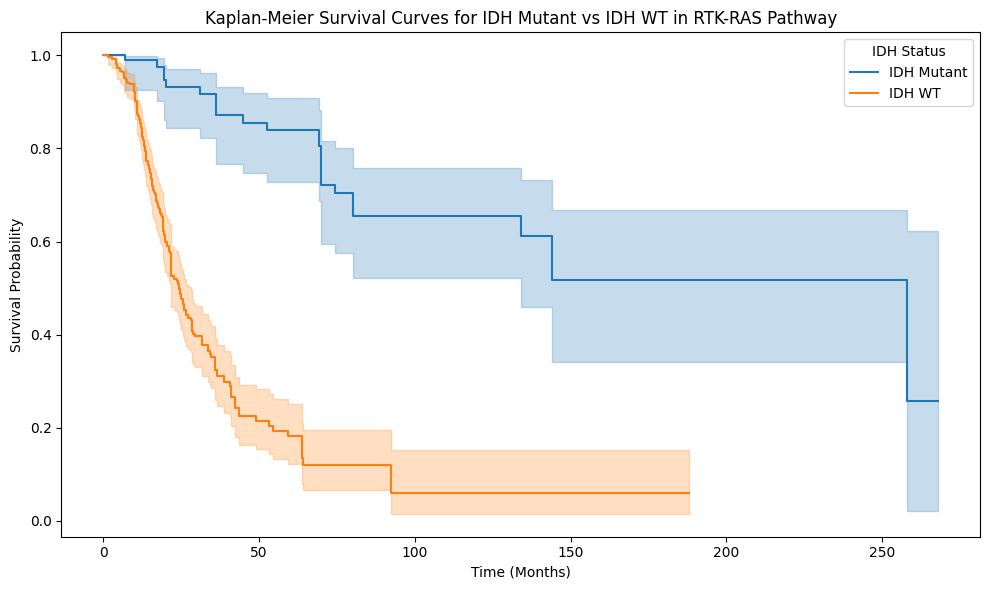

Log-rank test p-value between IDH Mutant and IDH WT for PI3K/AKT: 2.744613318913457e-24


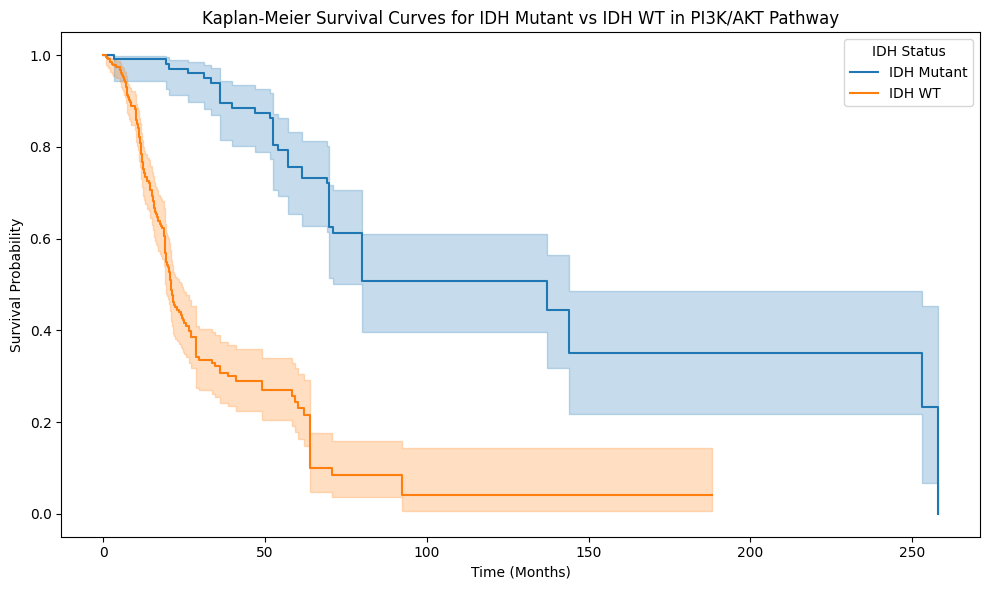

Log-rank test p-value between IDH Mutant and IDH WT for Histone methylation: 7.947422722930302e-20


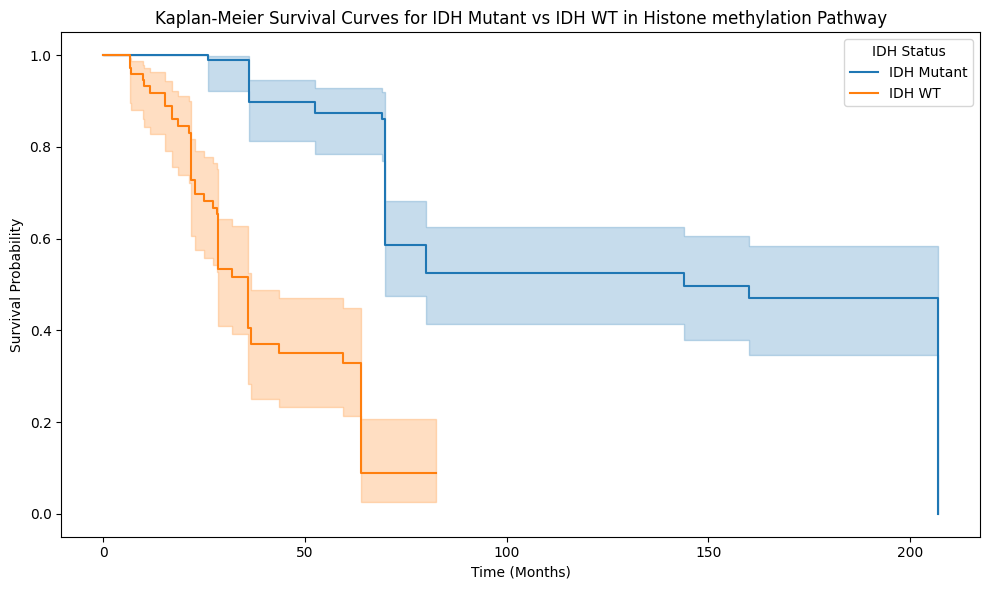

Log-rank test p-value between IDH Mutant and IDH WT for Astrocytic drivers: 1.3119308291444097e-52


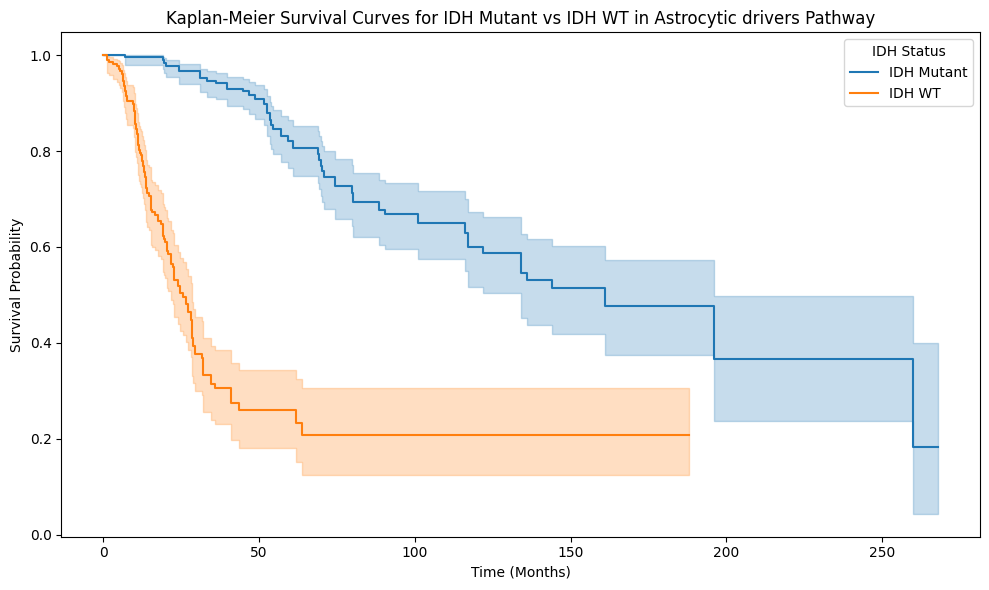

Log-rank test p-value between IDH Mutant and IDH WT for Telomere maintenance: 1.4756359176899952e-56


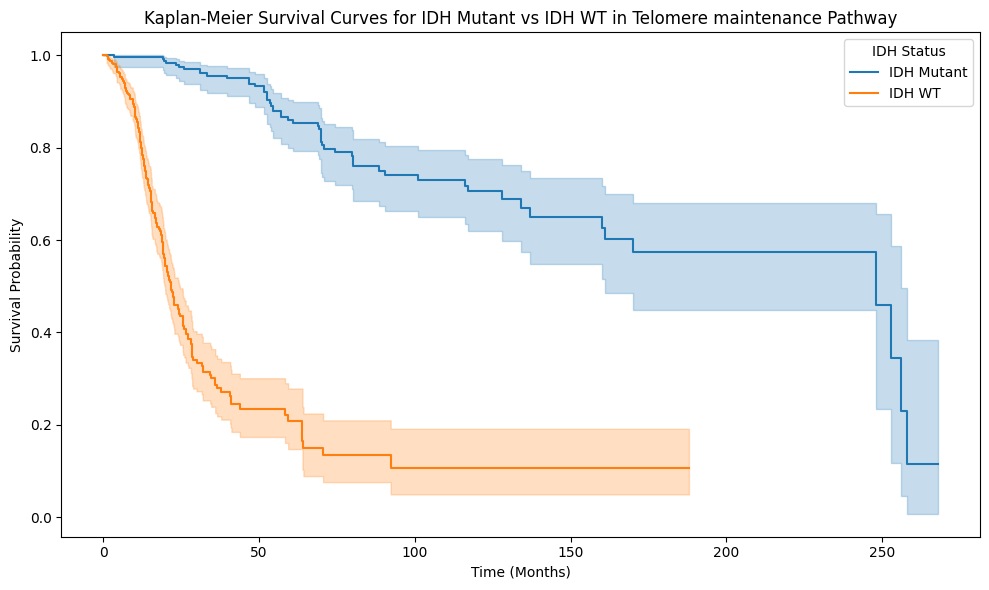

Log-rank test p-value between IDH Mutant and IDH WT for Cell-cycle control: 0.00888315602975044


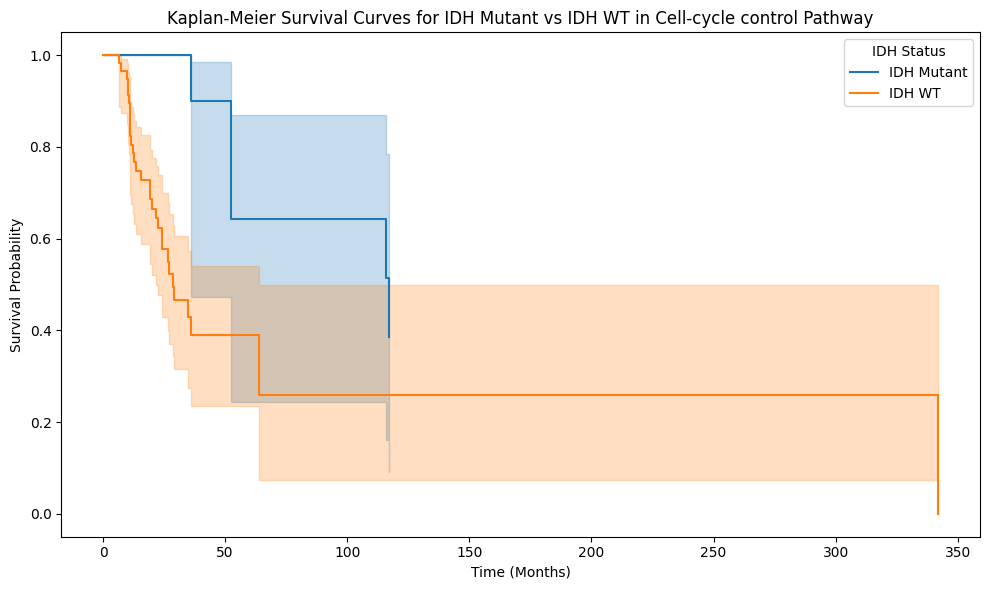

Log-rank test p-value between IDH Mutant and IDH WT for p53 signaling: 2.1493260099321885e-34


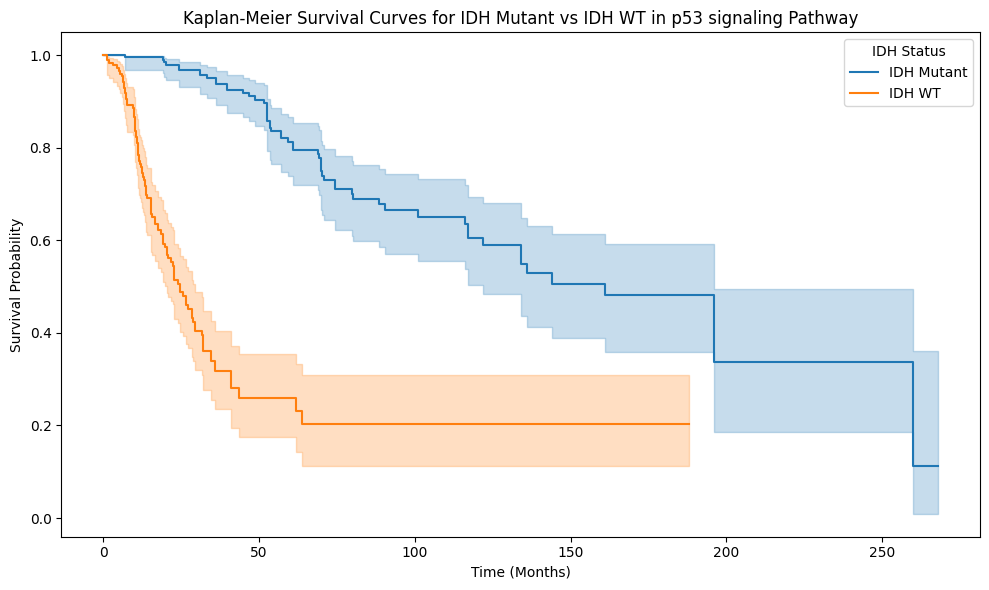

Log-rank test p-value between IDH Mutant and IDH WT for Chromatin remodeling: 2.2687749676575165e-21


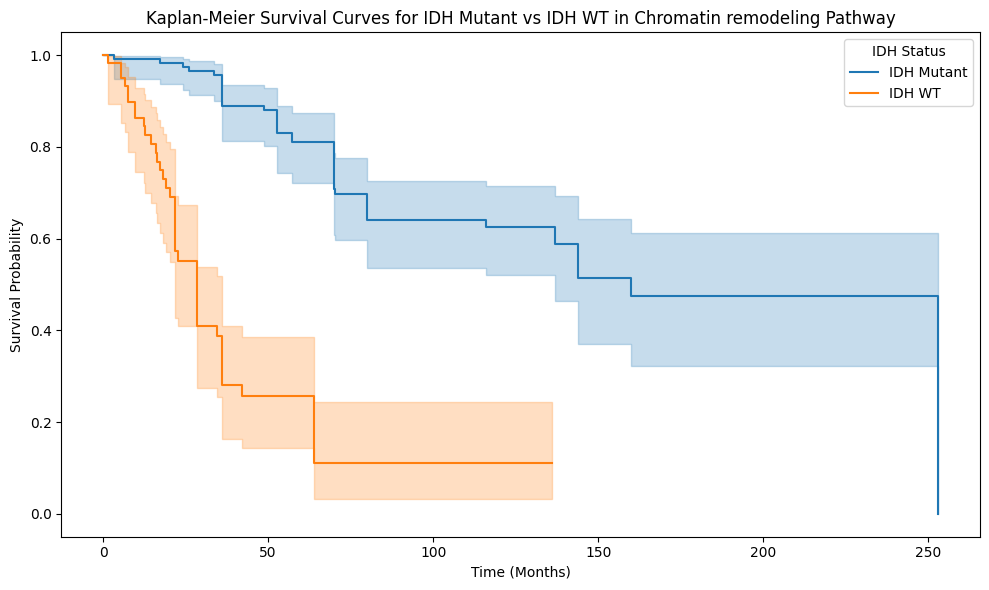

Log-rank test p-value between IDH Mutant and IDH WT for MYC/MAX signaling: 5.49525469267317e-08


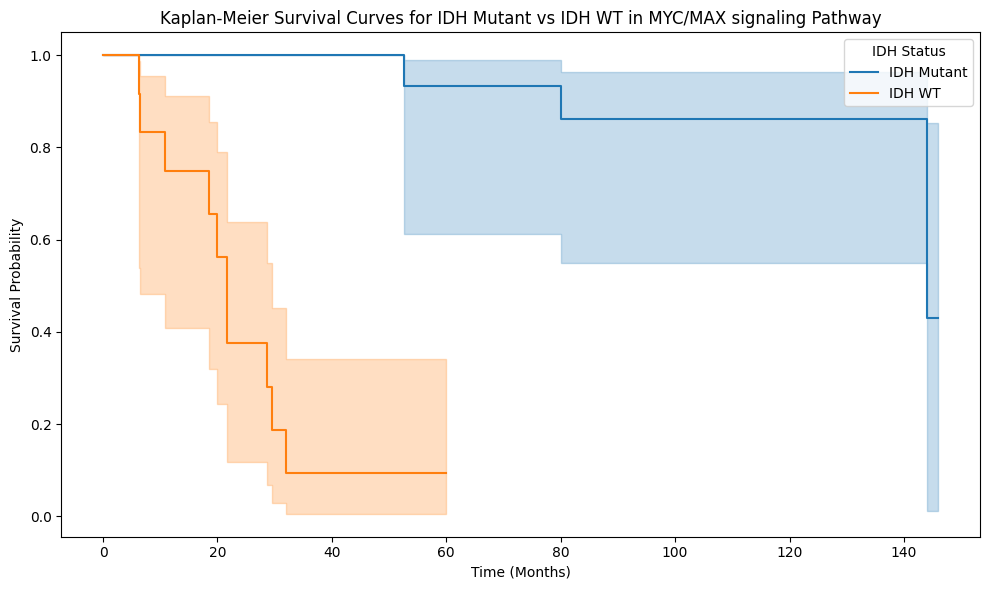

Log-rank test p-value between IDH Mutant and IDH WT for NOTCH pathway: 5.2744127953166066e-14


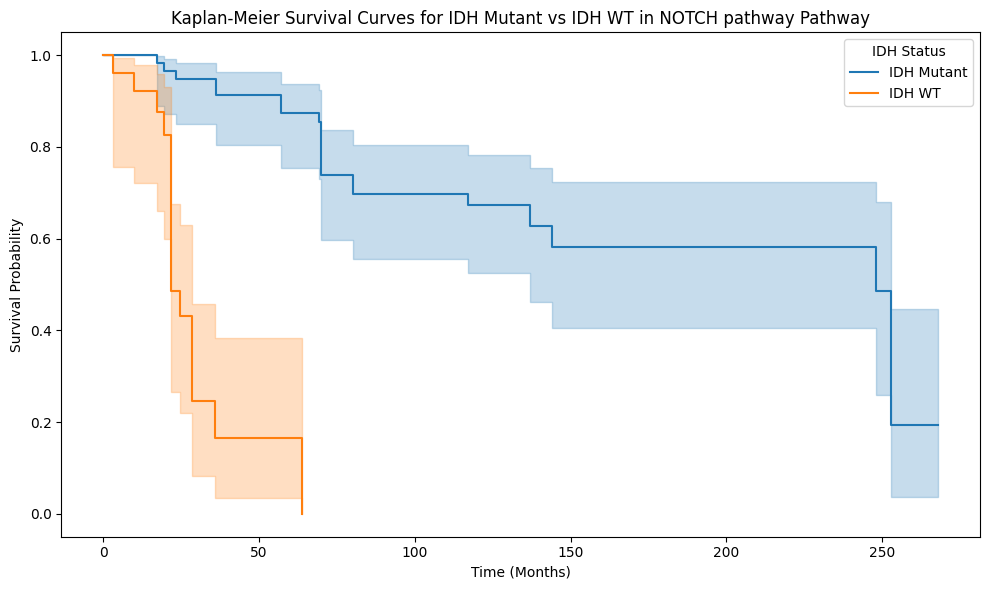

Log-rank test p-value between IDH Mutant and IDH WT for Oligodendroglial drivers: 1.2423439735452994e-09


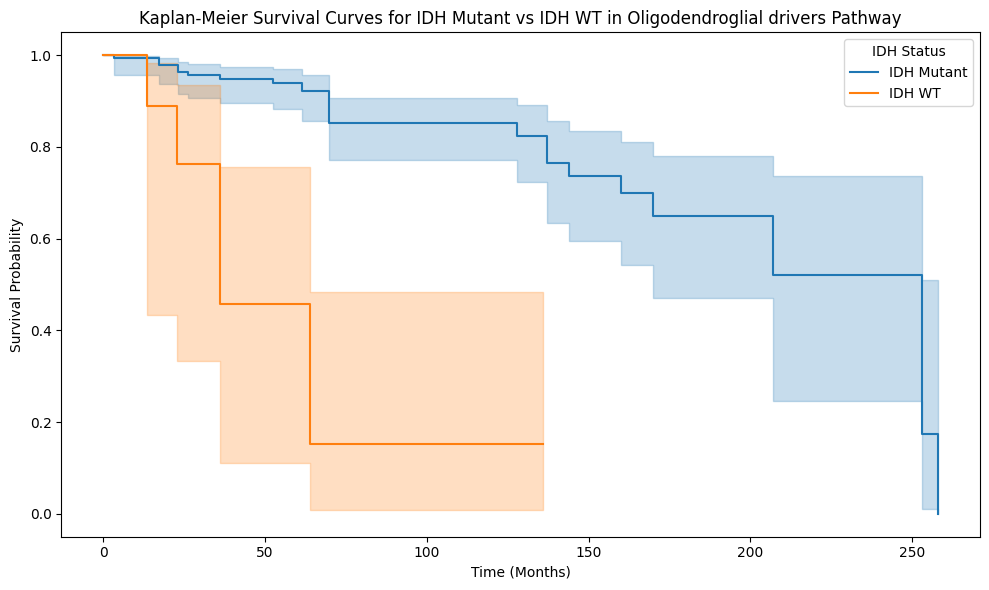

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Step 1: Clean the 'Overall Survival Status' to be binary (1 for deceased, 0 for living)
merged_df_clean['event_observed'] = merged_df_clean['Overall Survival Status'].apply(
    lambda x: 1 if isinstance(x, str) and 'DECEASED' in x else 0 if isinstance(x, str) and 'LIVING' in x else None
)

# Step 2: Filter out rows where 'Overall Survival (Months)' or 'event_observed' are NaN
cleaned_df = merged_df_clean.dropna(subset=['Overall Survival (Months)', 'event_observed'])

# Step 3: Assign 'IDH Status' based on mutations in IDH1 or IDH2 genes
idh_mutant_patients = cleaned_df[cleaned_df['Hugo_Symbol'].isin(['IDH1', 'IDH2'])]['Patient ID'].unique()
cleaned_df['IDH Status'] = cleaned_df['Patient ID'].apply(
    lambda pid: 'IDH Mutant' if pid in idh_mutant_patients else 'IDH WT'
)

# Step 4: Get all unique pathways (including 'none' as a separate pathway)
pathways = cleaned_df['Pathway'].unique()

# Step 5: Loop through all unique pathways and generate Kaplan-Meier plots
for pathway in pathways:
    pathway_data = cleaned_df[cleaned_df['Pathway'] == pathway]

    # Separate data into IDH Mutant and IDH WT groups
    idh_mutant_data = pathway_data[pathway_data['IDH Status'] == 'IDH Mutant']
    idh_wt_data = pathway_data[pathway_data['IDH Status'] == 'IDH WT']

    # Count patients in each group
    count_mutant = len(idh_mutant_data)
    count_wt = len(idh_wt_data)

    # Skip pathways with fewer than 2 patients in either group
    if count_mutant < 2 or count_wt < 2:
        print(f"Skipping {pathway} due to insufficient patients in one of the groups (IDH Mutant or IDH WT).")
        continue

    # Step 6: Plot Kaplan-Meier survival curves for both groups
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(10, 6))

    # Plot for IDH Mutant
    kmf.fit(idh_mutant_data['Overall Survival (Months)'], event_observed=idh_mutant_data['event_observed'], label='IDH Mutant')
    kmf.plot_survival_function()

    # Plot for IDH WT
    kmf.fit(idh_wt_data['Overall Survival (Months)'], event_observed=idh_wt_data['event_observed'], label='IDH WT')
    kmf.plot_survival_function()

    # Customize the plot
    plt.title(f'Kaplan-Meier Survival Curves for IDH Mutant vs IDH WT in {pathway} Pathway')
    plt.xlabel('Time (Months)')
    plt.ylabel('Survival Probability')
    plt.legend(title='IDH Status', loc='best')
    plt.tight_layout()

    # Step 7: Perform log-rank test between IDH Mutant and IDH WT
    results = logrank_test(
        idh_mutant_data['Overall Survival (Months)'],
        idh_wt_data['Overall Survival (Months)'],
        event_observed_A=idh_mutant_data['event_observed'],
        event_observed_B=idh_wt_data['event_observed']
    )

    # Print the p-value of the log-rank test
    print(f'Log-rank test p-value between IDH Mutant and IDH WT for {pathway}: {results.p_value}')

    # Show the plot
    plt.show()


<ipython-input-70-ae5a76fbe190>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_samples_df['event_observed'] = primary_samples_df['Overall Survival Status'].apply(


Log-rank test p-value between IDH Mutant and IDH WT for none: 3.865632116969907e-166


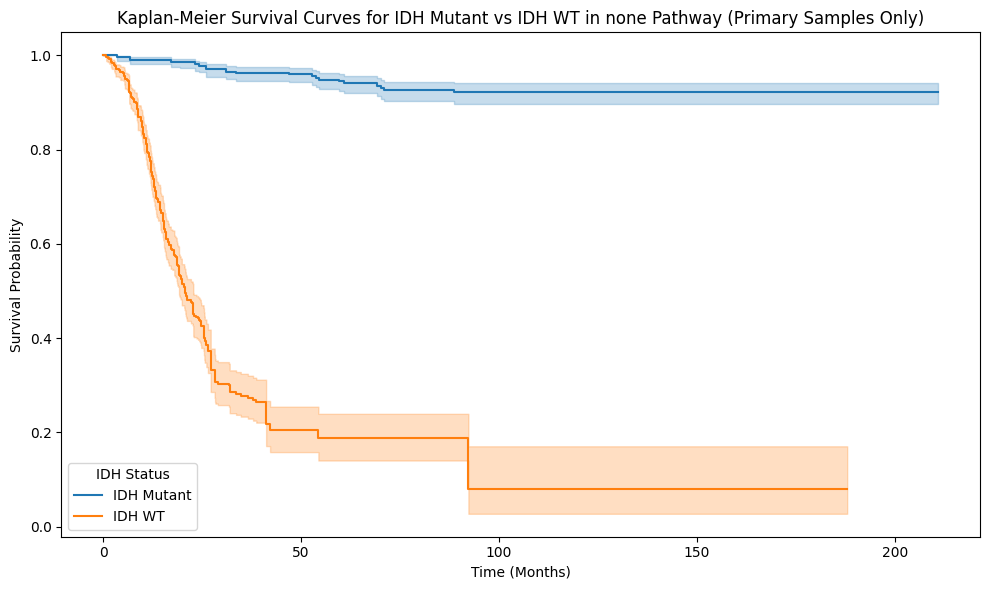

Log-rank test p-value between IDH Mutant and IDH WT for RTK-RAS: 4.7974302560138e-10


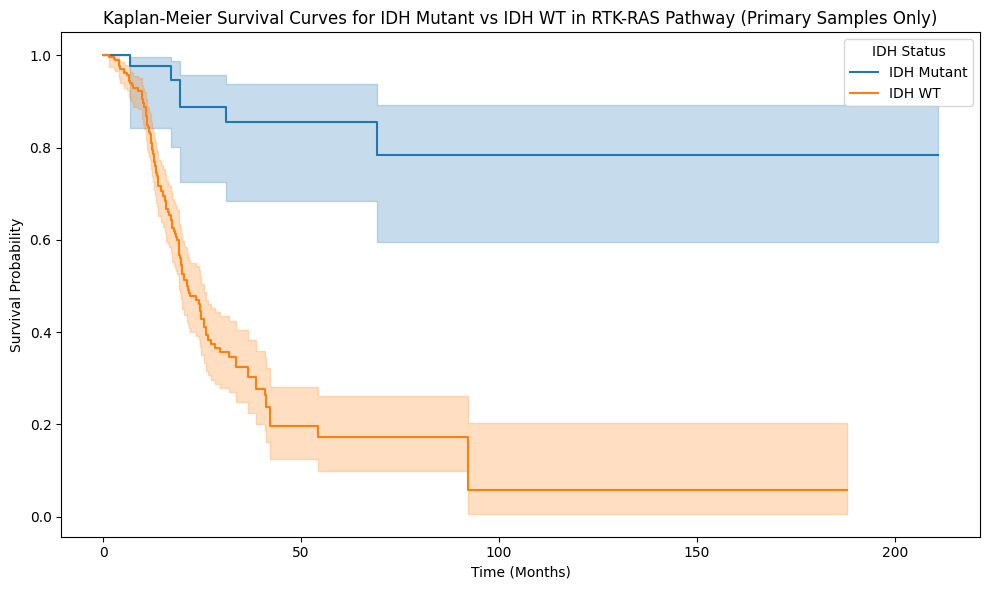

Log-rank test p-value between IDH Mutant and IDH WT for PI3K/AKT: 1.7583611781809058e-10


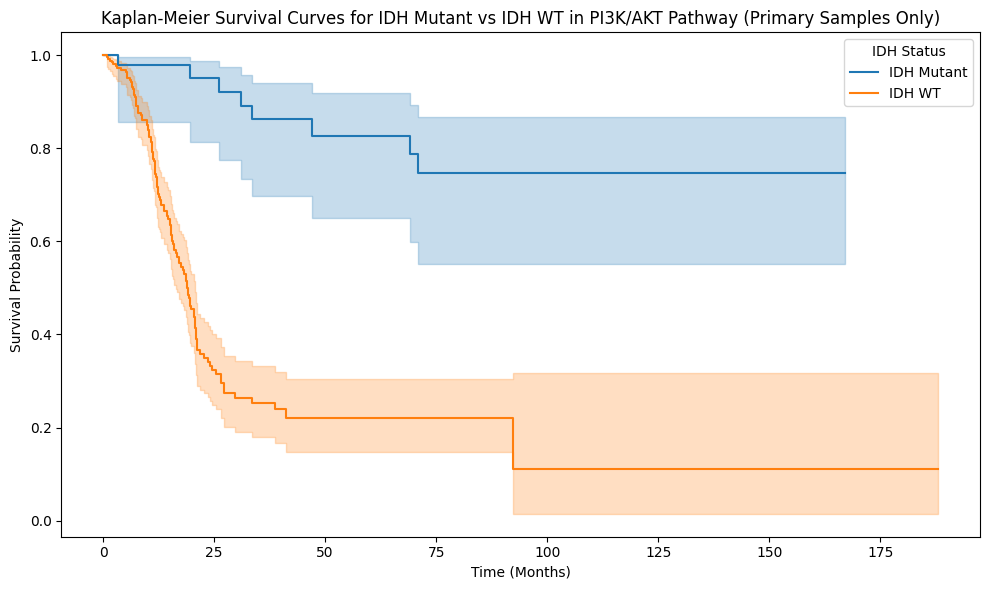

Log-rank test p-value between IDH Mutant and IDH WT for Histone methylation: 4.799677961226197e-07


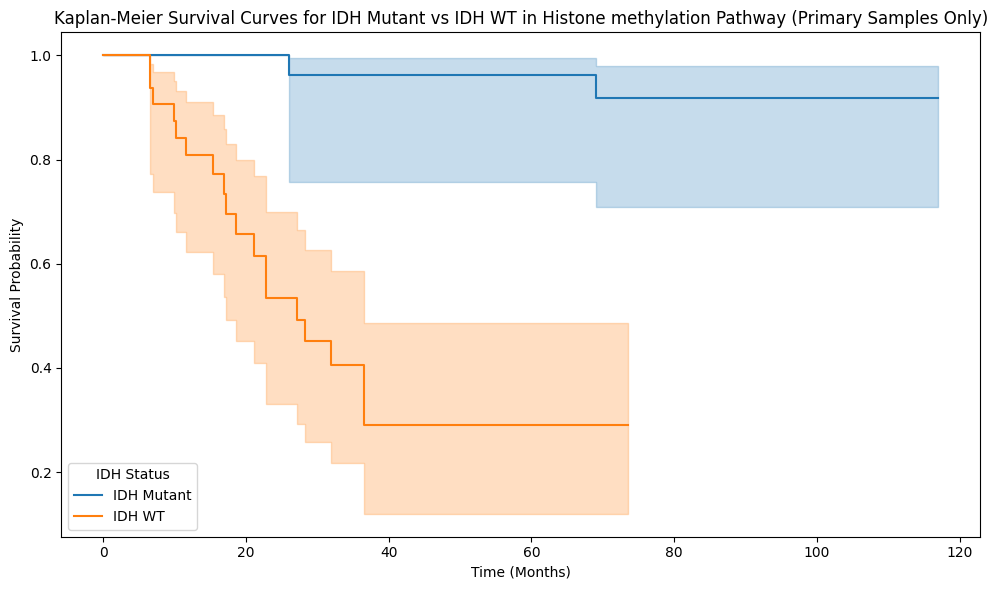

Log-rank test p-value between IDH Mutant and IDH WT for Astrocytic drivers: 1.8399450494413387e-37


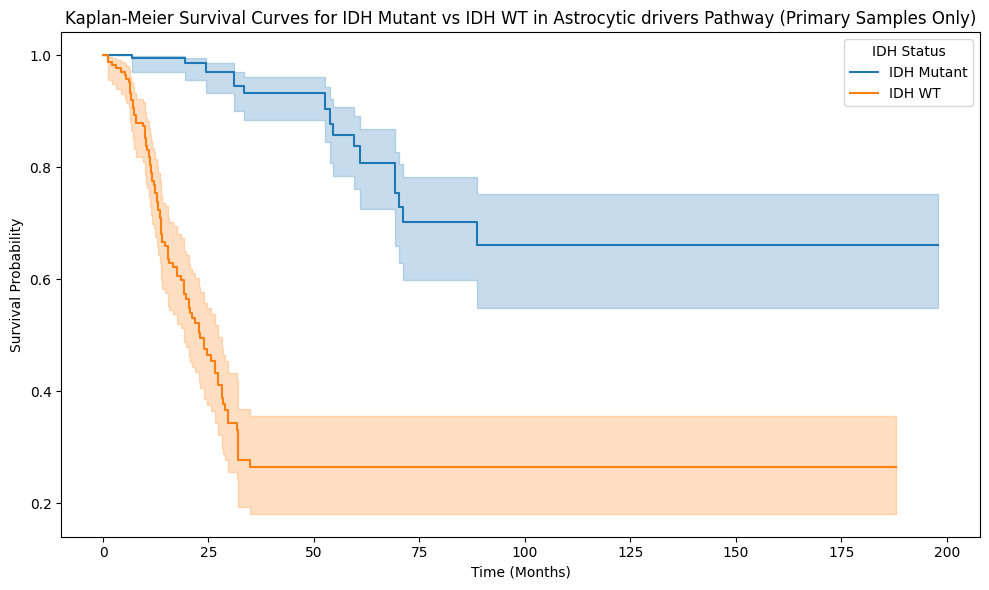

Log-rank test p-value between IDH Mutant and IDH WT for Telomere maintenance: 9.399175956353151e-38


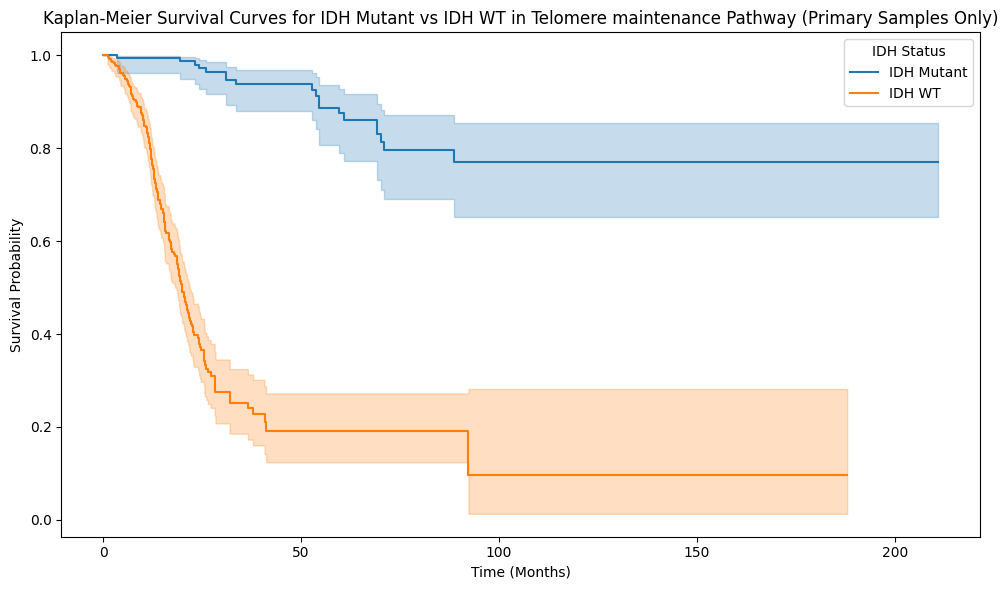

Log-rank test p-value between IDH Mutant and IDH WT for Cell-cycle control: 0.036528282861522016


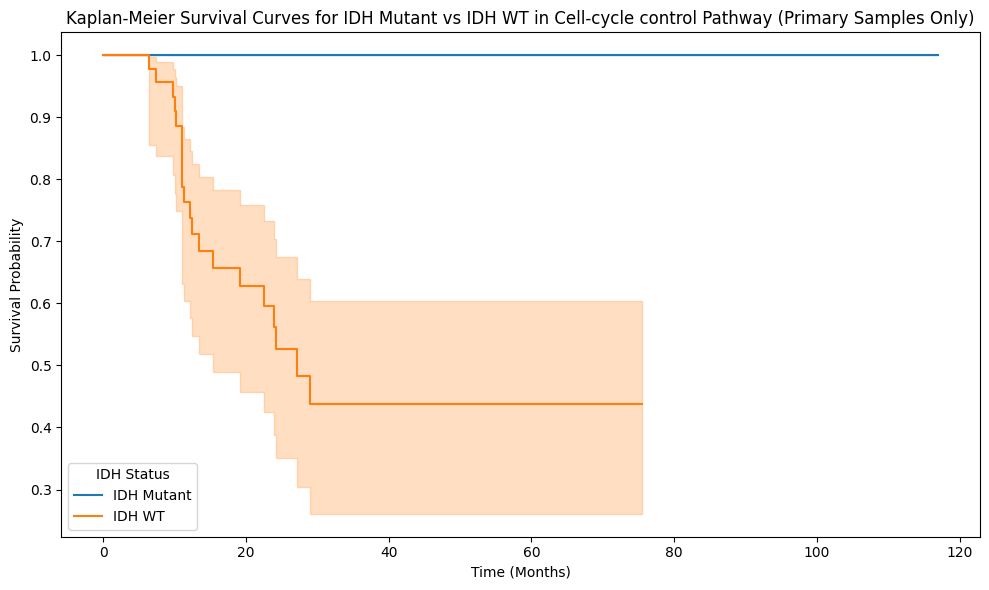

Log-rank test p-value between IDH Mutant and IDH WT for p53 signaling: 3.8560023815634315e-22


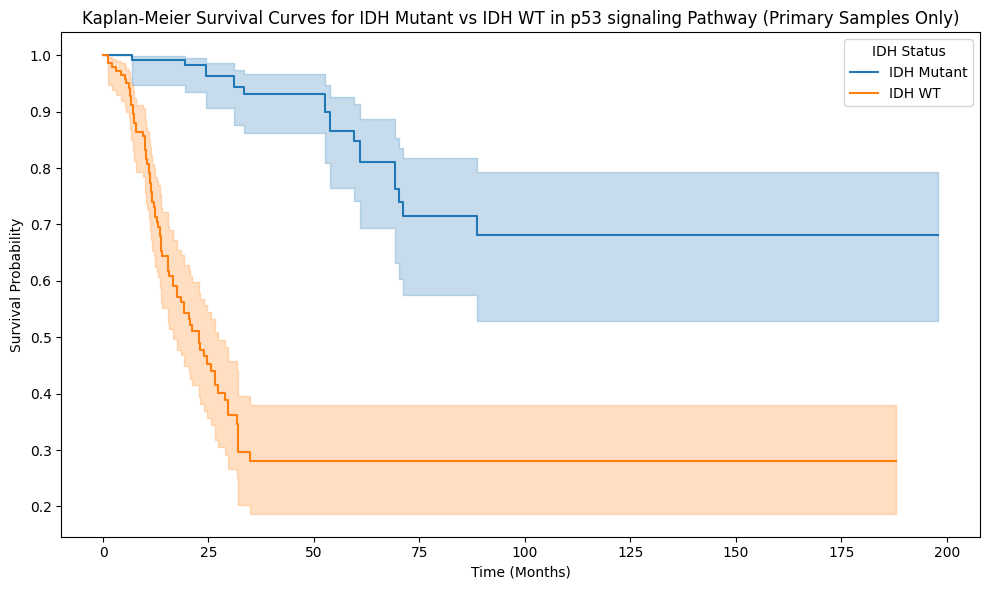

Log-rank test p-value between IDH Mutant and IDH WT for Chromatin remodeling: 2.2666633068120562e-14


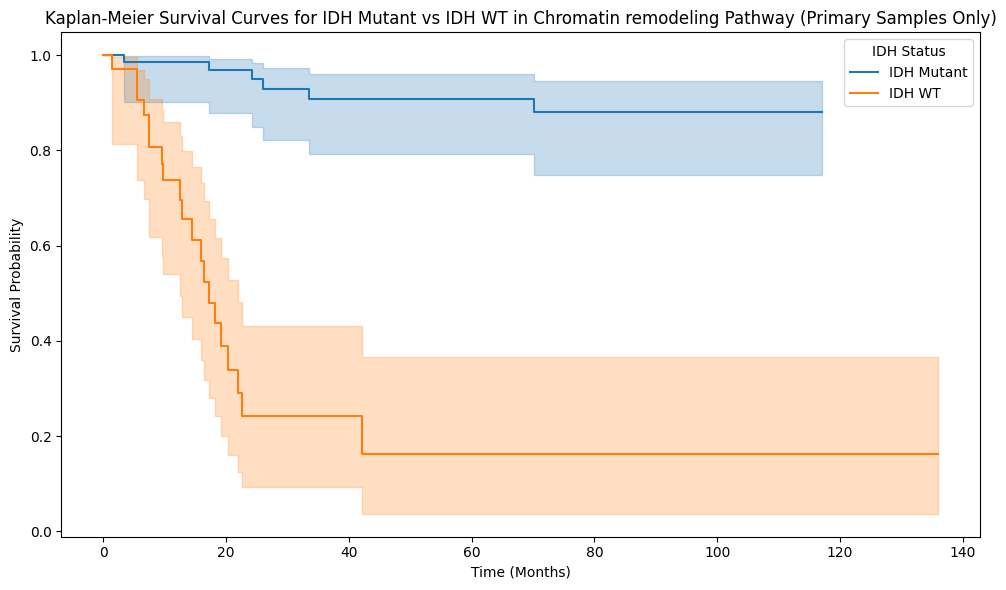

Log-rank test p-value between IDH Mutant and IDH WT for MYC/MAX signaling: 4.015605951479448e-07


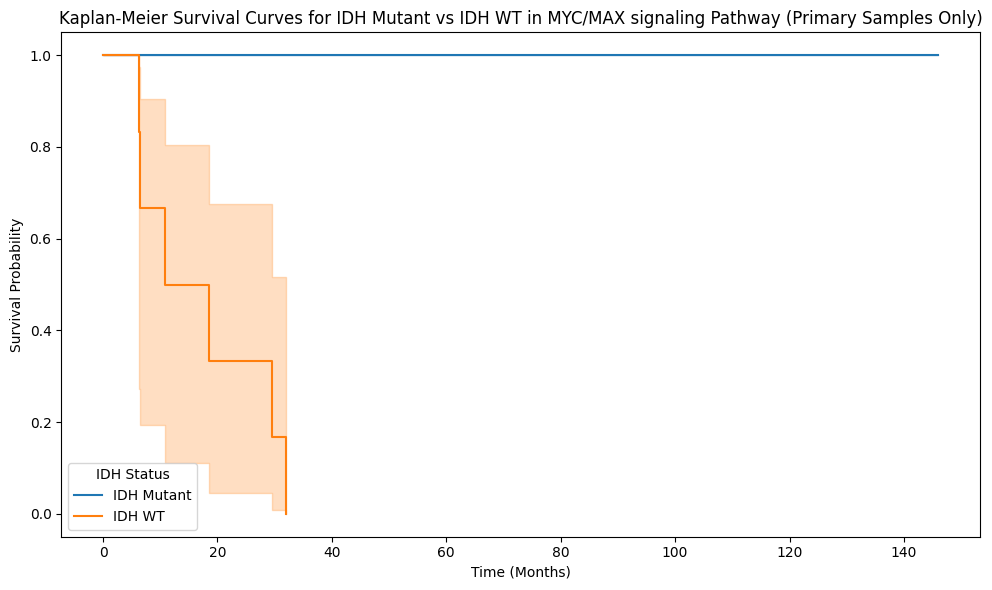

Log-rank test p-value between IDH Mutant and IDH WT for NOTCH pathway: 0.0005388686550290047


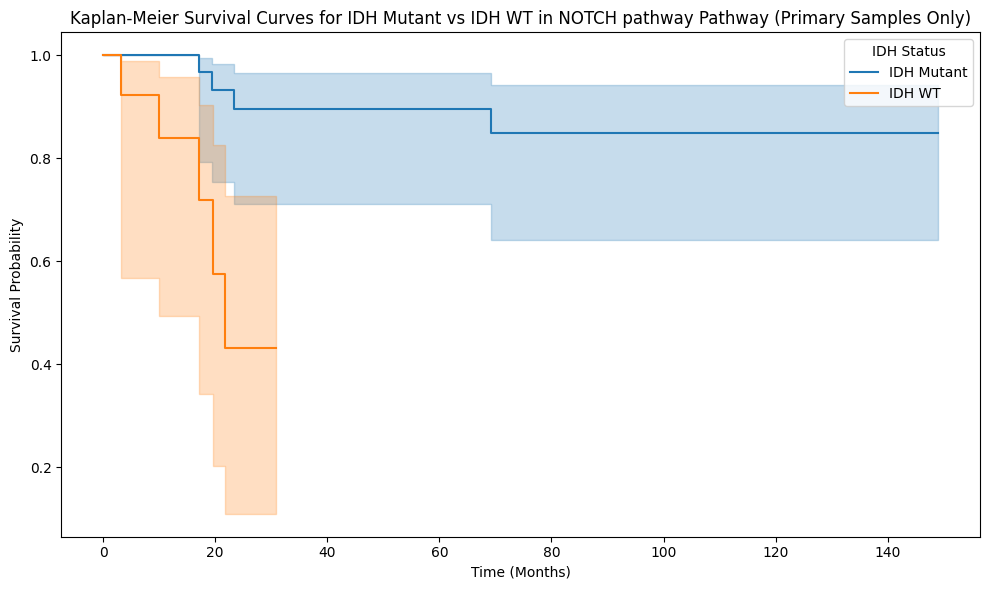

Log-rank test p-value between IDH Mutant and IDH WT for Oligodendroglial drivers: 0.000472600148103722


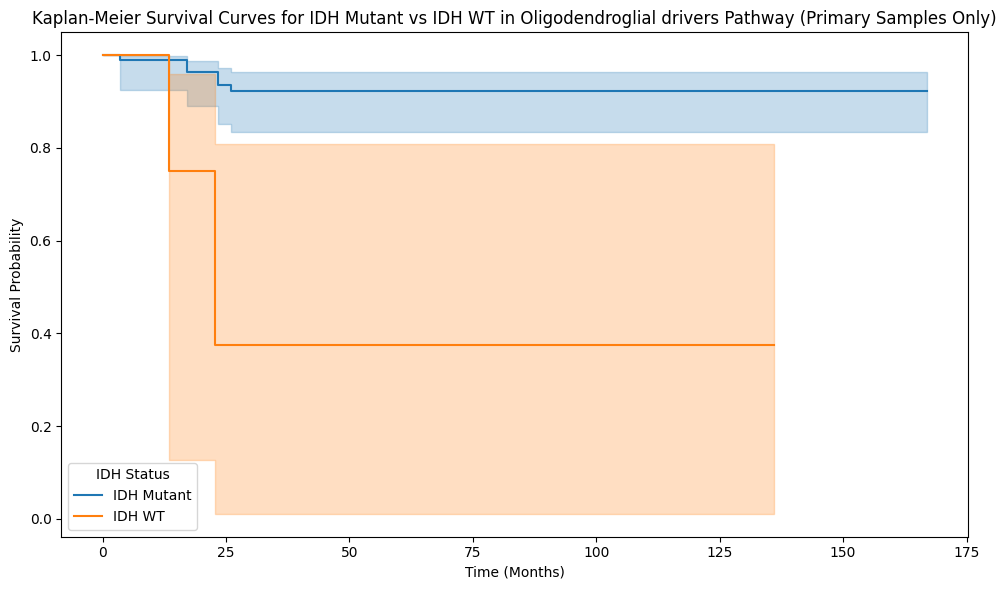

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Step 1: Keep only samples that have 'Primary' in the 'Sample Type' column
primary_samples_df = merged_df_clean[merged_df_clean['Sample Type'] == 'Primary']

# Step 2: Clean the 'Overall Survival Status' to be binary (1 for deceased, 0 for living)
primary_samples_df['event_observed'] = primary_samples_df['Overall Survival Status'].apply(
    lambda x: 1 if isinstance(x, str) and 'DECEASED' in x else 0 if isinstance(x, str) and 'LIVING' in x else None
)

# Step 3: Filter out rows where 'Overall Survival (Months)' or 'event_observed' are NaN
cleaned_df = primary_samples_df.dropna(subset=['Overall Survival (Months)', 'event_observed'])

# Step 4: Assign 'IDH Status' based on mutations in IDH1 or IDH2 genes
idh_mutant_patients = cleaned_df[cleaned_df['Hugo_Symbol'].isin(['IDH1', 'IDH2'])]['Patient ID'].unique()
cleaned_df['IDH Status'] = cleaned_df['Patient ID'].apply(
    lambda pid: 'IDH Mutant' if pid in idh_mutant_patients else 'IDH WT'
)

# Step 5: Get all unique pathways (including 'none' as a separate pathway)
pathways = cleaned_df['Pathway'].unique()

# Step 6: Loop through all unique pathways and generate Kaplan-Meier plots
for pathway in pathways:
    pathway_data = cleaned_df[cleaned_df['Pathway'] == pathway]

    # Separate data into IDH Mutant and IDH WT groups
    idh_mutant_data = pathway_data[pathway_data['IDH Status'] == 'IDH Mutant']
    idh_wt_data = pathway_data[pathway_data['IDH Status'] == 'IDH WT']

    # Count patients in each group
    count_mutant = len(idh_mutant_data)
    count_wt = len(idh_wt_data)

    # Skip pathways with fewer than 2 patients in either group
    if count_mutant < 2 or count_wt < 2:
        print(f"Skipping {pathway} due to insufficient patients in one of the groups (IDH Mutant or IDH WT).")
        continue

    # Step 7: Plot Kaplan-Meier survival curves for both groups
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(10, 6))

    # Plot for IDH Mutant
    kmf.fit(idh_mutant_data['Overall Survival (Months)'], event_observed=idh_mutant_data['event_observed'], label='IDH Mutant')
    kmf.plot_survival_function()

    # Plot for IDH WT
    kmf.fit(idh_wt_data['Overall Survival (Months)'], event_observed=idh_wt_data['event_observed'], label='IDH WT')
    kmf.plot_survival_function()

    # Customize the plot
    plt.title(f'Kaplan-Meier Survival Curves for IDH Mutant vs IDH WT in {pathway} Pathway (Primary Samples Only)')
    plt.xlabel('Time (Months)')
    plt.ylabel('Survival Probability')
    plt.legend(title='IDH Status', loc='best')
    plt.tight_layout()

    # Step 8: Perform log-rank test between IDH Mutant and IDH WT
    results = logrank_test(
        idh_mutant_data['Overall Survival (Months)'],
        idh_wt_data['Overall Survival (Months)'],
        event_observed_A=idh_mutant_data['event_observed'],
        event_observed_B=idh_wt_data['event_observed']
    )

    # Print the p-value of the log-rank test
    print(f'Log-rank test p-value between IDH Mutant and IDH WT for {pathway}: {results.p_value}')

    # Show the plot
    plt.show()


**Progress free comparison between IDH WT and IDH mutant**

<ipython-input-90-5b256c016801>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['IDH Status'] = filtered_df['Patient ID'].apply(
<ipython-input-90-5b256c016801>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['event_observed'] = filtered_df['Progression Free Status'].apply(


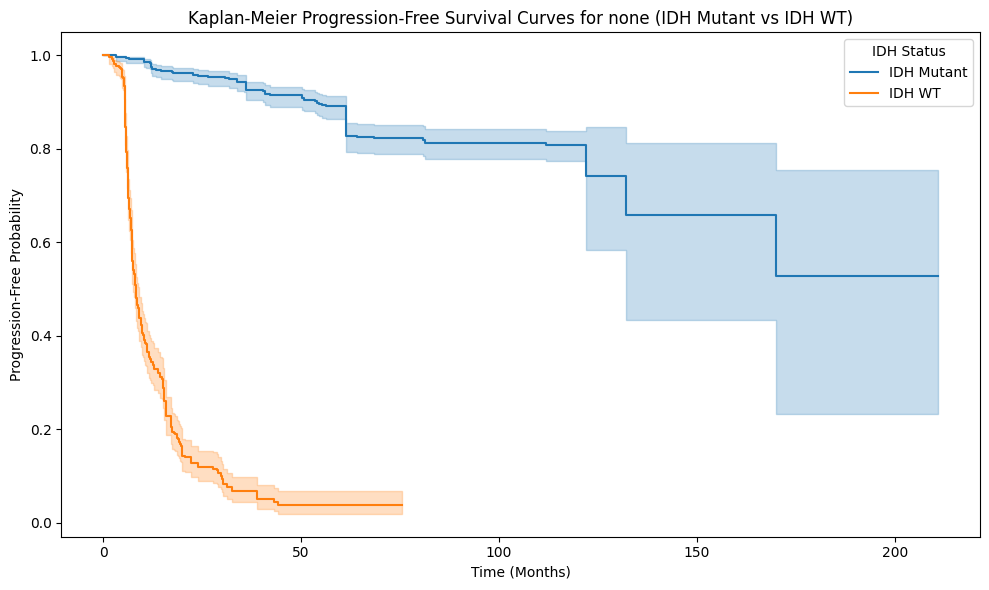

Log-rank test p-value for none between IDH Mutant and IDH WT: 1.8948453241854339e-261
Number of patients in none: IDH Mutant = 820, IDH WT = 444


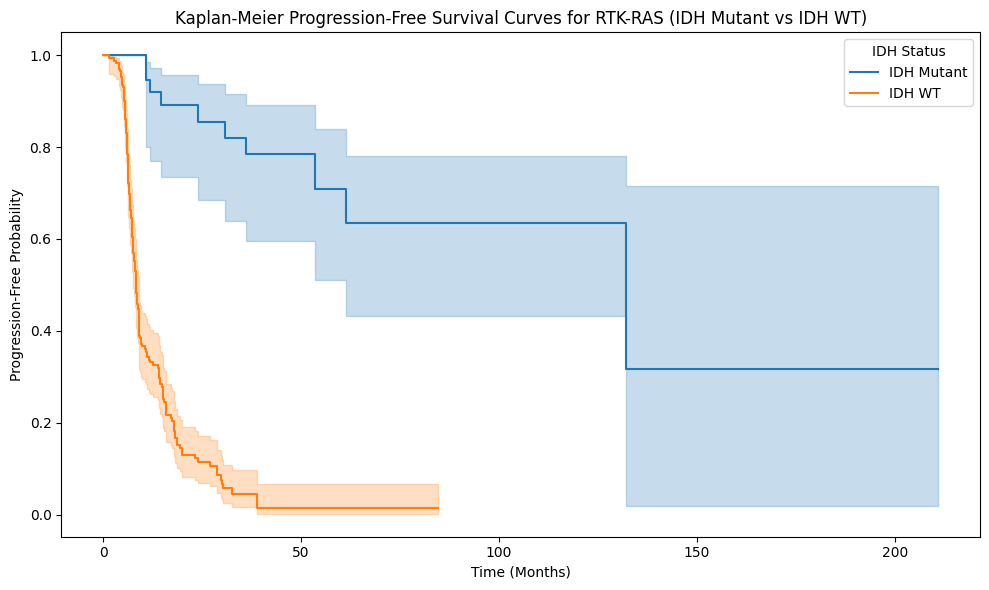

Log-rank test p-value for RTK-RAS between IDH Mutant and IDH WT: 1.4910188988827514e-17
Number of patients in RTK-RAS: IDH Mutant = 46, IDH WT = 177


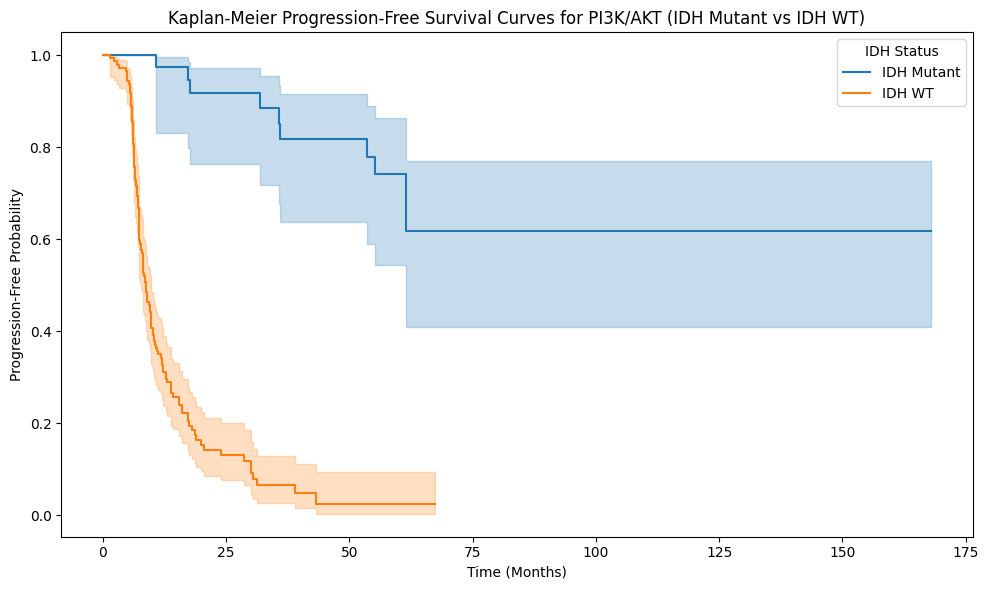

Log-rank test p-value for PI3K/AKT between IDH Mutant and IDH WT: 7.55502929157302e-19
Number of patients in PI3K/AKT: IDH Mutant = 49, IDH WT = 150


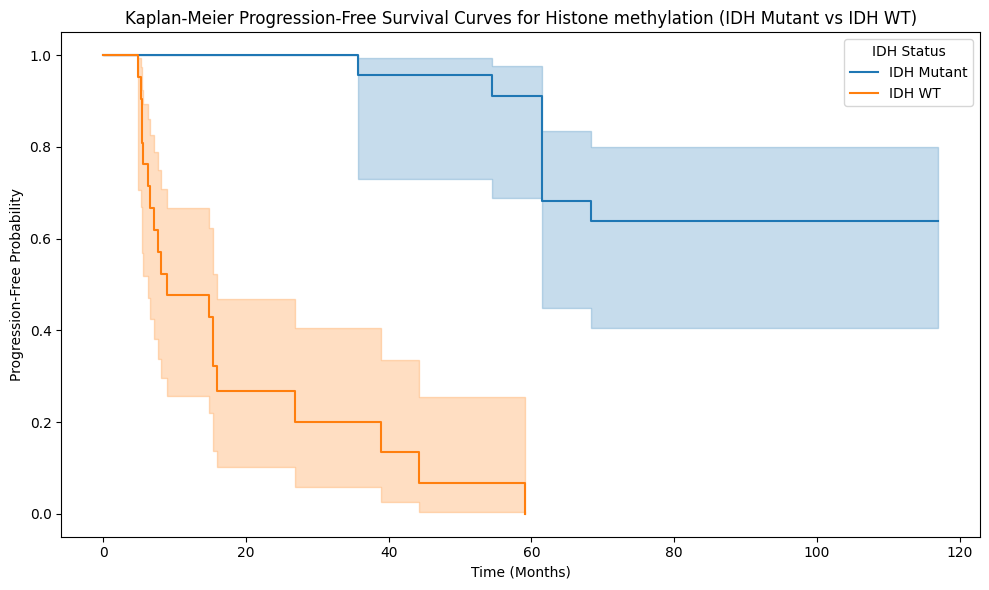

Log-rank test p-value for Histone methylation between IDH Mutant and IDH WT: 1.7619427724659111e-13
Number of patients in Histone methylation: IDH Mutant = 32, IDH WT = 23


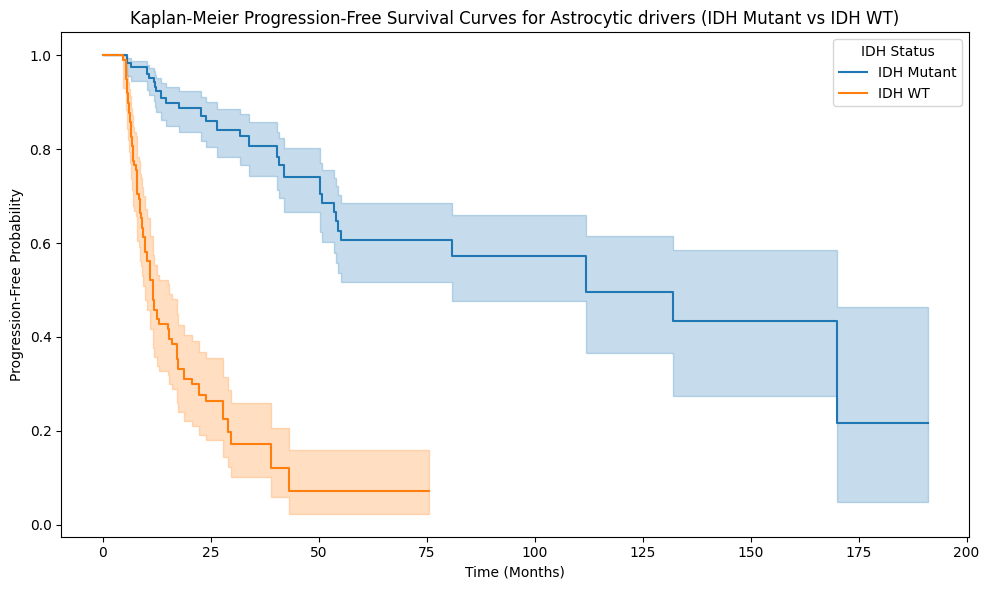

Log-rank test p-value for Astrocytic drivers between IDH Mutant and IDH WT: 1.2237157747689002e-40
Number of patients in Astrocytic drivers: IDH Mutant = 270, IDH WT = 103


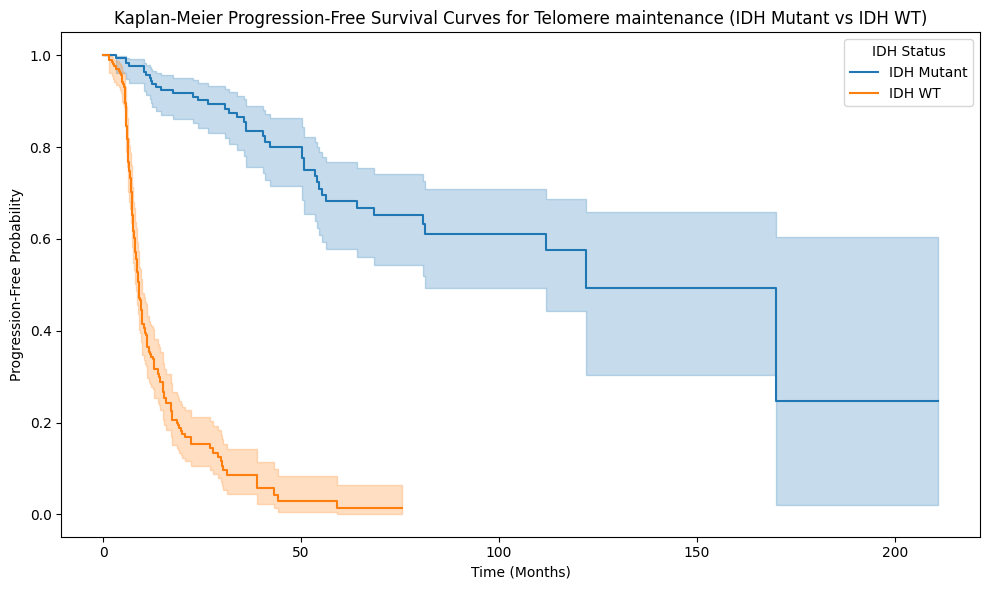

Log-rank test p-value for Telomere maintenance between IDH Mutant and IDH WT: 1.084804729290048e-54
Number of patients in Telomere maintenance: IDH Mutant = 195, IDH WT = 209


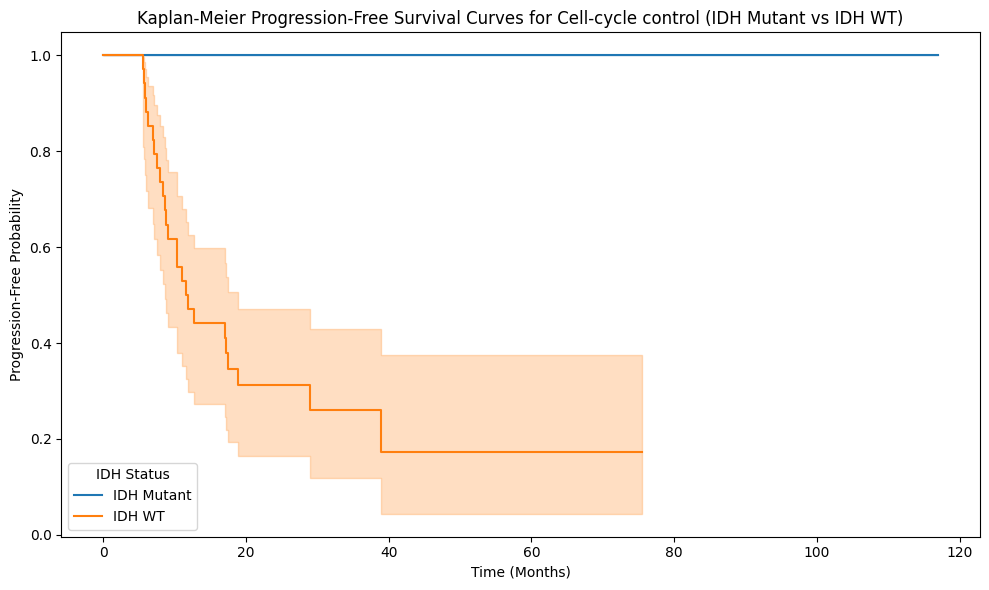

Log-rank test p-value for Cell-cycle control between IDH Mutant and IDH WT: 0.004455952959328264
Number of patients in Cell-cycle control: IDH Mutant = 6, IDH WT = 35


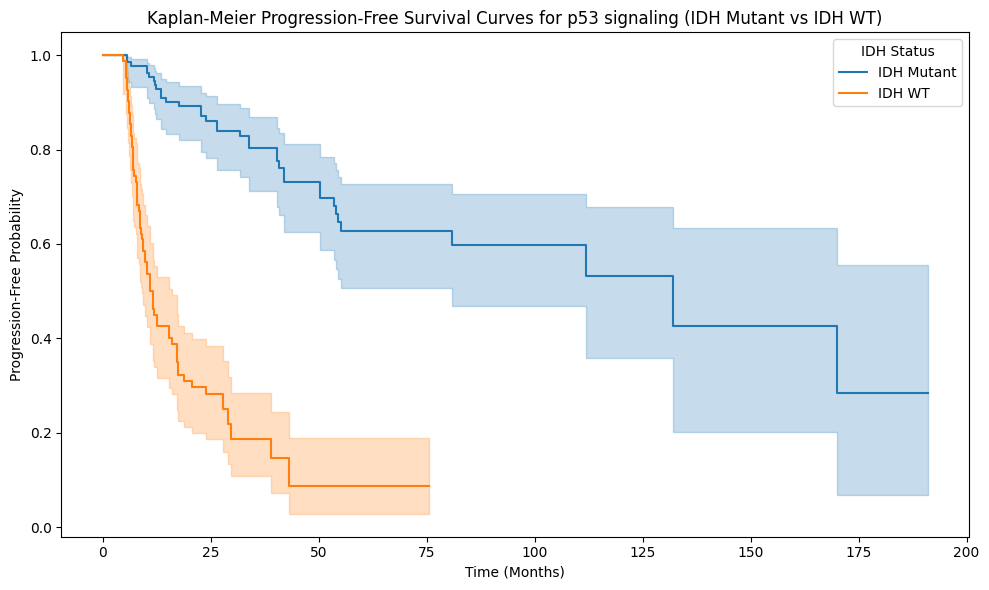

Log-rank test p-value for p53 signaling between IDH Mutant and IDH WT: 5.227678281246392e-25
Number of patients in p53 signaling: IDH Mutant = 154, IDH WT = 85


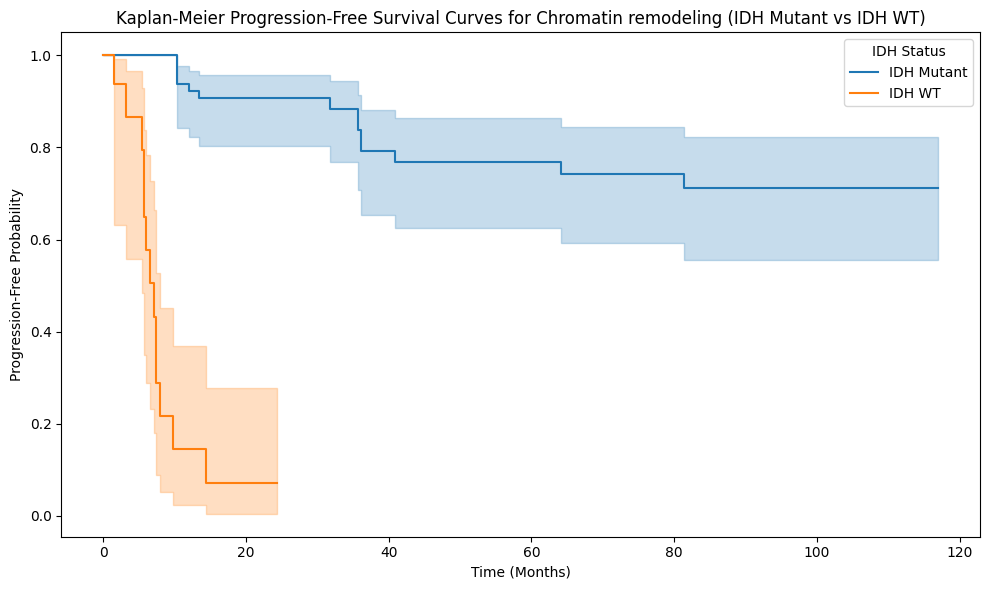

Log-rank test p-value for Chromatin remodeling between IDH Mutant and IDH WT: 8.250626331138223e-22
Number of patients in Chromatin remodeling: IDH Mutant = 71, IDH WT = 16


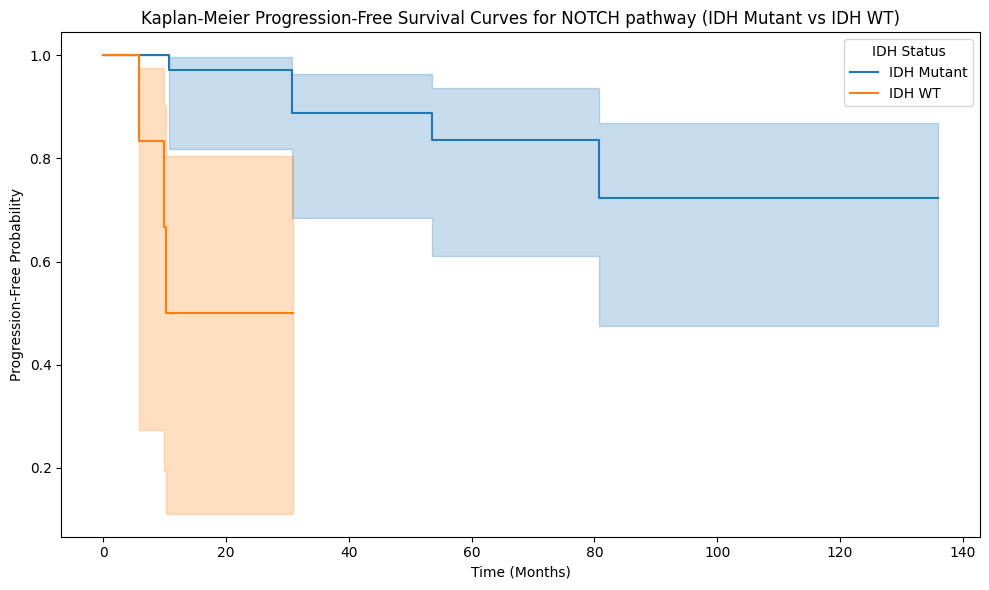

Log-rank test p-value for NOTCH pathway between IDH Mutant and IDH WT: 0.0002768005176461247
Number of patients in NOTCH pathway: IDH Mutant = 41, IDH WT = 9


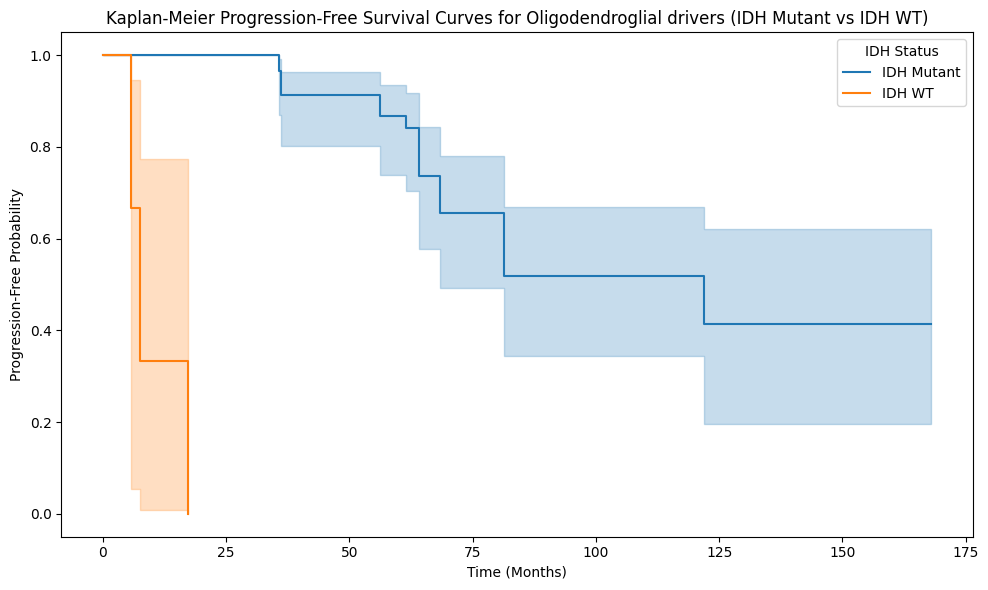

Log-rank test p-value for Oligodendroglial drivers between IDH Mutant and IDH WT: 1.3624131728195337e-29
Number of patients in Oligodendroglial drivers: IDH Mutant = 112, IDH WT = 3


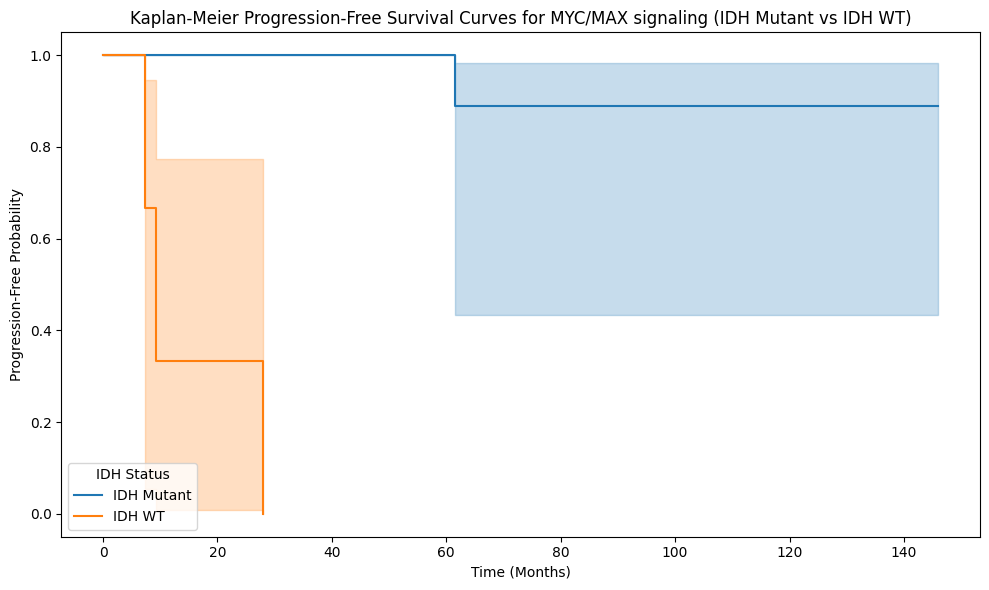

Log-rank test p-value for MYC/MAX signaling between IDH Mutant and IDH WT: 2.3629345504289913e-06
Number of patients in MYC/MAX signaling: IDH Mutant = 17, IDH WT = 4


In [90]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Step 1: Filter to keep only 'Primary' samples
filtered_df = merged_df_clean[merged_df_clean['Sample Type'] == 'Primary']

# Step 2: Assign IDH Status based on mutations in IDH1 or IDH2
idh_mutant_patients = filtered_df[filtered_df['Hugo_Symbol'].isin(['IDH1', 'IDH2'])]['Patient ID'].unique()
filtered_df['IDH Status'] = filtered_df['Patient ID'].apply(
    lambda pid: 'IDH Mutant' if pid in idh_mutant_patients else 'IDH WT'
)

# Step 3: Clean 'Progression Free Status' to be binary (1 for progression, 0 for no progression)
filtered_df['event_observed'] = filtered_df['Progression Free Status'].apply(
    lambda x: 1 if 'PROGRESSION' in str(x).upper() else 0
)

# Step 4: Drop rows with missing values in 'Progress Free Survival (Months)' and 'event_observed'
filtered_df = filtered_df.dropna(subset=['Progress Free Survival (Months)', 'event_observed'])

# Step 5: Get all unique pathways
pathways = filtered_df['Pathway'].unique()

# Step 6: Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Step 7: Loop through each pathway and perform progression-free survival analysis
for pathway in pathways:
    # Filter data for the pathway
    pathway_data = filtered_df[filtered_df['Pathway'] == pathway]

    # Check if both groups (IDH Mutant and IDH WT) have at least 2 patients
    idh_mutant_count = pathway_data[pathway_data['IDH Status'] == 'IDH Mutant'].shape[0]
    idh_wt_count = pathway_data[pathway_data['IDH Status'] == 'IDH WT'].shape[0]

    if idh_mutant_count < 2 or idh_wt_count < 2:
        print(f"Skipping {pathway} due to insufficient patients in one of the groups (IDH Mutant or IDH WT).")
        continue

    # Plot Kaplan-Meier curves
    plt.figure(figsize=(10, 6))

    # Plot for IDH Mutant
    idh_mutant_data = pathway_data[pathway_data['IDH Status'] == 'IDH Mutant']
    kmf.fit(idh_mutant_data['Progress Free Survival (Months)'], event_observed=idh_mutant_data['event_observed'], label='IDH Mutant')
    kmf.plot_survival_function()

    # Plot for IDH WT
    idh_wt_data = pathway_data[pathway_data['IDH Status'] == 'IDH WT']
    kmf.fit(idh_wt_data['Progress Free Survival (Months)'], event_observed=idh_wt_data['event_observed'], label='IDH WT')
    kmf.plot_survival_function()

    # Customize the plot
    plt.title(f'Kaplan-Meier Progression-Free Survival Curves for {pathway} (IDH Mutant vs IDH WT)')
    plt.xlabel('Time (Months)')
    plt.ylabel('Progression-Free Probability')
    plt.legend(title='IDH Status', loc='best')
    plt.tight_layout()

    # Step 8: Perform log-rank test
    results = logrank_test(
        idh_mutant_data['Progress Free Survival (Months)'],
        idh_wt_data['Progress Free Survival (Months)'],
        event_observed_A=idh_mutant_data['event_observed'],
        event_observed_B=idh_wt_data['event_observed']
    )

    # Step 9: Show the plot
    plt.show()

    # Print the p-value of the log-rank test
    print(f'Log-rank test p-value for {pathway} between IDH Mutant and IDH WT: {results.p_value}')

    # Step 10: Count the number of patients in each group for reference
    print(f'Number of patients in {pathway}: IDH Mutant = {idh_mutant_count}, IDH WT = {idh_wt_count}')


**Genetic aberrations frequency in tumors depending on IDH status**

In [93]:
import pandas as pd

# Step 1: Identify patients with mutations in IDH1 or IDH2
idh_mutant_patients = merged_df_clean[merged_df_clean['Hugo_Symbol'].isin(['IDH1', 'IDH2'])]['Patient ID'].unique()

# Step 2: Assign IDH Status to each patient based on whether they are IDH mutant or IDH WT
merged_df_clean['IDH Status'] = merged_df_clean['Patient ID'].apply(
    lambda pid: 'IDH Mutant' if pid in idh_mutant_patients else 'IDH WT'
)

# Step 3: Separate data for IDH Mutant and IDH WT groups
idh_mutant_df = merged_df_clean[merged_df_clean['IDH Status'] == 'IDH Mutant']
idh_wt_df = merged_df_clean[merged_df_clean['IDH Status'] == 'IDH WT']

# Step 4: Get the top 20 most frequently mutated genes for each group
def get_top_genes(group_df):
    gene_counts = group_df['Hugo_Symbol'].value_counts()  # Count how often each gene appears
    top_genes = gene_counts.head(20)  # Get top 20 genes
    return top_genes

# Top 20 genes for IDH Mutant group
top_genes_mutant = get_top_genes(idh_mutant_df)

# Top 20 genes for IDH WT group
top_genes_wt = get_top_genes(idh_wt_df)

# Step 5: Print the results
print("Top 20 most frequently mutated genes in IDH Mutant group:")
print(top_genes_mutant)

print("\nTop 20 most frequently mutated genes in IDH WT group:")
print(top_genes_wt)


Top 20 most frequently mutated genes in IDH Mutant group:
Hugo_Symbol
TP53       472
ATRX       340
IDH1       292
CIC        146
TERT       129
NOTCH1      64
KMT2D       50
PIK3CA      41
FUBP1       38
ARID1A      37
SMARCA4     34
FAT1        33
KMT2C       31
NF1         29
BRCA2       27
ARID1B      27
SPEN        26
POLE        26
IDH2        26
PIK3R1      25
Name: count, dtype: int64

Top 20 most frequently mutated genes in IDH WT group:
Hugo_Symbol
TERT      391
TP53      378
PTEN      196
EGFR      156
NF1       128
ATRX       82
PIK3CA     64
RB1        59
PIK3R1     55
PDGFRA     35
PTPN11     31
STAG2      30
SETD2      30
KMT2D      27
SPEN       19
BRAF       19
MED12      18
NOTCH1     17
FAT1       17
NOTCH3     17
Name: count, dtype: int64


<ipython-input-93-7b7ee7df51c4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_clean['IDH Status'] = merged_df_clean['Patient ID'].apply(


<ipython-input-92-fb1d15b34414>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['IDH Status'] = filtered_df['Patient ID'].apply(
<ipython-input-92-fb1d15b34414>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['WHO Grade Grouped'] = filtered_df['WHO Grade'].replace({


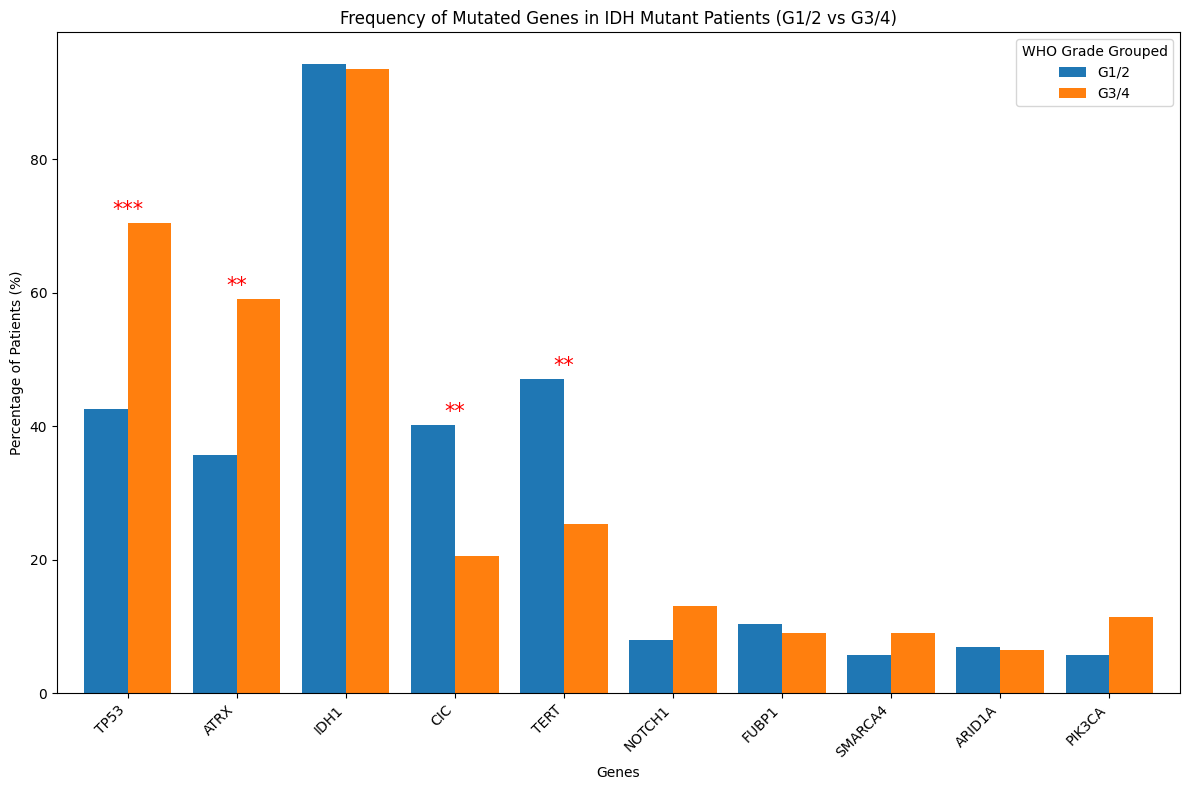

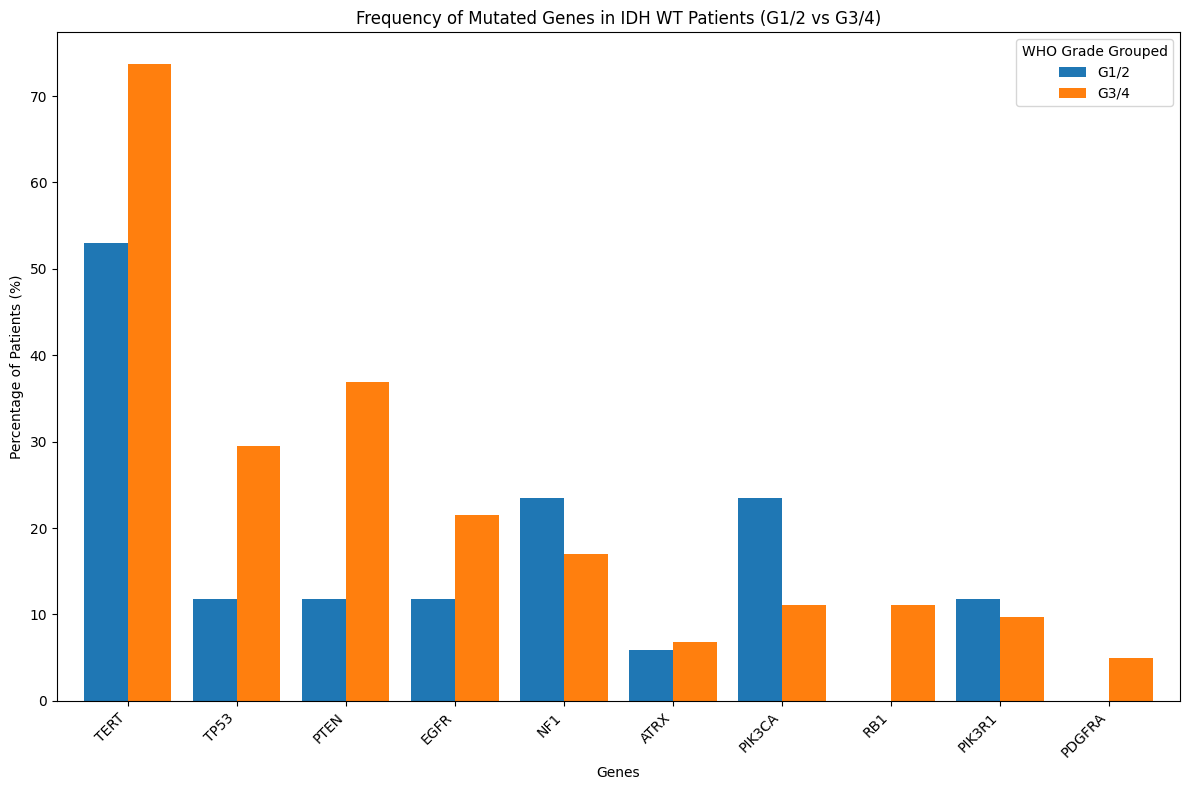

P-values for IDH Mutant group: {'TP53': 9.349926079053693e-05, 'ATRX': 0.0014086152241363683, 'IDH1': 1.0, 'CIC': 0.003135697176242796, 'TERT': 0.0018768660536552875, 'NOTCH1': 0.35234961425773026, 'FUBP1': 0.9336075761815299, 'SMARCA4': 0.5402997085379526, 'ARID1A': 1.0, 'PIK3CA': 0.2396250080573616}
P-values for IDH WT group: {'TERT': 0.10703400472904334, 'TP53': 0.19037993242921664, 'PTEN': 0.06203556477203186, 'EGFR': 0.5056014085076787, 'NF1': 0.7103477253772728, 'ATRX': 1.0, 'PIK3CA': 0.23629549422541501, 'RB1': 0.2916322347191192, 'PIK3R1': 1.0, 'PDGFRA': 0.7144145526985215}


In [92]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Step 1: Remove 'Recurrence' from the Sample Type column
filtered_df = merged_df_clean[merged_df_clean['Sample Type'] != 'Recurrence']

# Step 2: Assign IDH Status based on mutations in IDH1 or IDH2
idh_mutant_patients = filtered_df[filtered_df['Hugo_Symbol'].isin(['IDH1', 'IDH2'])]['Patient ID'].unique()
filtered_df['IDH Status'] = filtered_df['Patient ID'].apply(
    lambda pid: 'IDH Mutant' if pid in idh_mutant_patients else 'IDH WT'
)

# Step 3: Identify top 10 most frequently mutated genes in each IDH group
top_genes_idh_mutant = filtered_df[filtered_df['IDH Status'] == 'IDH Mutant']['Hugo_Symbol'].value_counts().nlargest(10).index
top_genes_idh_wt = filtered_df[filtered_df['IDH Status'] == 'IDH WT']['Hugo_Symbol'].value_counts().nlargest(10).index

# Step 4: Group WHO Grades
filtered_df['WHO Grade Grouped'] = filtered_df['WHO Grade'].replace({
    'G1': 'G1/2',
    'G1/G2': 'G1/2',
    'G2': 'G1/2',
    'G3': 'G3/4',
    'G3/G4': 'G3/4',
    'G4': 'G3/4'
})
filtered_df = filtered_df[filtered_df['WHO Grade'] != 'Indeterminate']  # Filter out 'Indeterminate'

# Step 5: Calculate the percentage of patients with mutations in each gene (G1/2 and G3/4 groups)
def calculate_gene_percentage(df, top_genes):
    percentages = {}
    for gene in top_genes:
        # Count the number of unique patients in G1/2 and G3/4 groups who have mutations in each gene
        gene_counts = df[df['Hugo_Symbol'] == gene].groupby('WHO Grade Grouped')['Patient ID'].nunique()
        total_patients_per_group = df.groupby('WHO Grade Grouped')['Patient ID'].nunique()
        gene_percentage = (gene_counts / total_patients_per_group * 100).fillna(0)  # Ensure no NaNs
        percentages[gene] = gene_percentage
    return pd.DataFrame(percentages).T

# Calculate percentages for IDH Mutant and IDH WT groups
mutant_df = filtered_df[filtered_df['IDH Status'] == 'IDH Mutant']
wt_df = filtered_df[filtered_df['IDH Status'] == 'IDH WT']

percentages_mutant = calculate_gene_percentage(mutant_df, top_genes_idh_mutant)
percentages_wt = calculate_gene_percentage(wt_df, top_genes_idh_wt)

# Step 6: Perform chi-square test for each gene between G1/2 and G3/4 within IDH Mutant and IDH WT groups
def perform_chi_square_test(df, top_genes):
    p_values = {}
    for gene in top_genes:
        gene_counts = df[df['Hugo_Symbol'] == gene].groupby('WHO Grade Grouped')['Patient ID'].nunique()
        total_patients_per_group = df.groupby('WHO Grade Grouped')['Patient ID'].nunique()
        contingency_table = [[gene_counts.get('G1/2', 0), total_patients_per_group.get('G1/2', 0) - gene_counts.get('G1/2', 0)],
                             [gene_counts.get('G3/4', 0), total_patients_per_group.get('G3/4', 0) - gene_counts.get('G3/4', 0)]]

        # Perform chi-square test
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        p_values[gene] = p
    return p_values

# Perform chi-square test for both groups
p_values_mutant = perform_chi_square_test(mutant_df, top_genes_idh_mutant)
p_values_wt = perform_chi_square_test(wt_df, top_genes_idh_wt)

# Step 7: Plot bar charts with percentages and p-values
def plot_gene_distribution(percentages, p_values, idh_status):
    ax = percentages.plot(kind='bar', figsize=(12, 8), width=0.8)
    ax.set_ylabel('Percentage of Patients (%)')
    ax.set_xlabel('Genes')
    ax.set_title(f'Frequency of Mutated Genes in {idh_status} Patients (G1/2 vs G3/4)')
    plt.xticks(rotation=45, ha='right')

    # Add p-values with stars
    for i, gene in enumerate(percentages.index):
        p = p_values[gene]
        if p < 0.001:
            ax.text(i, max(percentages.loc[gene]) + 1, '***', ha='center', color='red', fontsize=15)
        elif p < 0.01:
            ax.text(i, max(percentages.loc[gene]) + 1, '**', ha='center', color='red', fontsize=15)
        elif p < 0.05:
            ax.text(i, max(percentages.loc[gene]) + 1, '*', ha='center', color='red', fontsize=15)

    plt.tight_layout()
    plt.show()

# Plot for IDH Mutant
plot_gene_distribution(percentages_mutant, p_values_mutant, 'IDH Mutant')

# Plot for IDH WT
plot_gene_distribution(percentages_wt, p_values_wt, 'IDH WT')

# Print p-values for reference
print("P-values for IDH Mutant group:", p_values_mutant)
print("P-values for IDH WT group:", p_values_wt)
